## Electricity

In [9]:
    shapefile_dir = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile"  # Directory containing all yearly shapefiles
    electricity_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/전기에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity"

In [17]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
from datetime import datetime

def identify_unique_address_buildings(buildings_gdf):
    """
    Identify buildings with unique addresses (not shared with other buildings)
    """
    # Count occurrences of each address
    address_counts = buildings_gdf['Street num'].value_counts()
    
    # Find addresses that appear only once
    unique_addresses = address_counts[address_counts == 1].index
    
    # Filter buildings to keep only unique addresses
    unique_buildings = buildings_gdf[buildings_gdf['Street num'].isin(unique_addresses)].copy()
    
    print(f"Total buildings: {len(buildings_gdf)}")
    print(f"Buildings with unique addresses: {len(unique_buildings)}")
    print(f"Buildings with shared addresses: {len(buildings_gdf) - len(unique_buildings)}")
    
    return unique_buildings

def calculate_eui_for_buildings(shapefile_dir, energy_excel_path, output_path=None):
    """
    Match energy data to buildings and calculate EUI for unique-address buildings
    """
    print("\nStep 1: Loading energy consumption data...")
    energy_df = pd.read_excel(energy_excel_path)
    print(f"Loaded {len(energy_df)} energy records")
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    print("\nStep 2: Processing energy data by year...")
    all_matched_data = []
    
    # Get unique years in energy data
    years = sorted(energy_df['year'].unique())
    print(f"Years in energy data: {years}")
    
    for year in years:
        print(f"\n" + "-"*50)
        print(f"Processing year {year}...")
        
        # Find corresponding shapefile
        shapefile_name = f"Shapefile_{year}.shp"
        shapefile_path = os.path.join(shapefile_dir, shapefile_name)
        
        # Check if shapefile exists
        if not os.path.exists(shapefile_path):
            print(f"WARNING: Shapefile not found: {shapefile_path}")
            print(f"Skipping year {year}")
            continue
        
        # Load shapefile for this specific year
        print(f"Loading shapefile: {shapefile_path}")
        year_buildings = gpd.read_file(shapefile_path)
        
        # Get only buildings with unique addresses for this year
        year_unique_buildings = identify_unique_address_buildings(year_buildings)
        
        # Filter energy data for this year
        year_energy = energy_df[energy_df['year'] == year]
        
        # Match with buildings
        matched = year_unique_buildings.merge(
            year_energy,
            left_on='Street num',
            right_on='address_key',
            how='inner'
        )
        
        # Calculate EUI if GFA column exists
        if 'GFA (m2)' in matched.columns:
            # Calculate EUI (kWh/m²)
            matched['EUI'] = matched['사용량(KWh)'] / matched['GFA (m2)']
            matched['EUI'] = matched['EUI'].round(2)
        else:
            print("Warning: GFA (m2) column not found in shapefile. EUI calculation skipped.")
            print(f"Available columns: {list(matched.columns)}")
        
        all_matched_data.append(matched)
    
    # Combine all matched data
    if all_matched_data:
        final_matched = pd.concat(all_matched_data, ignore_index=True)
    else:
        final_matched = gpd.GeoDataFrame()
    
    print(f"\nTotal matched records: {len(final_matched)}")
    
    # Create summary table (years as rows, months as columns)
    print(f"\nStep 3: Creating summary table...")
    
    if len(final_matched) > 0:
        # Count unique buildings per year-month
        summary = final_matched.groupby(['year', 'month'])['Street num'].nunique().reset_index()
        summary.columns = ['year', 'month', 'building_count']
        
        # Pivot to create the desired table format
        summary_table = summary.pivot(index='year', columns='month', values='building_count')
        summary_table = summary_table.fillna(0).astype(int)
        
        # Add month names as column headers
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        summary_table.columns = [month_names[i-1] for i in summary_table.columns]
        
        # Add total column
        summary_table['Total'] = summary_table.sum(axis=1)
        
        print("\nBuilding Count Summary (Unique Address Buildings with Energy Data):")
        print(summary_table)
    else:
        summary_table = pd.DataFrame()
    
    # Save results if output path provided
    if output_path and len(final_matched) > 0:
        # Save matched data with EUI
        output_base = output_path.rsplit('.', 1)[0]
        
        # Option 1: Save as GeoPackage (better Unicode support)
        try:
            final_matched.to_file(f"{output_base}_with_eui.gpkg", driver='GPKG')
            print(f"Saved as GeoPackage: {output_base}_with_eui.gpkg")
        except:
            # Option 2: Save shapefile with only ASCII column names
            print("Unicode error saving shapefile. Saving with English column names...")
            final_matched_eng = final_matched.copy()
            # Rename columns with Korean characters
            column_mapping = {
                '사용년월': 'usage_period',
                '사용량(KWh)': 'usage_kwh',
                '번': 'bun',
                '지': 'ji'
            }
            for kor, eng in column_mapping.items():
                if kor in final_matched_eng.columns:
                    final_matched_eng = final_matched_eng.rename(columns={kor: eng})
            final_matched_eng.to_file(f"{output_base}_with_eui.shp")
        
        # Save summary table
        summary_table.to_csv(f"{output_base}_summary.csv", encoding='utf-8-sig')
        
        # Save detailed CSV with all data
        csv_columns = ['Street num', 'year', 'month', '사용량(KWh)', 'GFA (m2)', 'EUI'] 
        csv_columns = [col for col in csv_columns if col in final_matched.columns]
        final_matched[csv_columns].to_csv(f"{output_base}_detailed.csv", index=False, encoding='utf-8-sig')
        
        print(f"\nResults saved to:")
        print(f"- {output_base}_with_eui.shp")
        print(f"- {output_base}_summary.csv")
        print(f"- {output_base}_detailed.csv")
    
    return final_matched, summary_table

def analyze_eui_statistics(matched_data):
    """
    Analyze EUI statistics by year and month
    """
    if 'EUI' not in matched_data.columns or len(matched_data) == 0:
        print("No EUI data available for analysis")
        return
    
    print("\n" + "="*60)
    print("EUI STATISTICS ANALYSIS")
    print("="*60)
    
    # Overall statistics
    print("\nOverall EUI Statistics:")
    print(f"Mean EUI: {matched_data['EUI'].mean():.2f} kWh/m²")
    print(f"Median EUI: {matched_data['EUI'].median():.2f} kWh/m²")
    print(f"Std Dev: {matched_data['EUI'].std():.2f} kWh/m²")
    print(f"Min EUI: {matched_data['EUI'].min():.2f} kWh/m²")
    print(f"Max EUI: {matched_data['EUI'].max():.2f} kWh/m²")
    
    # Yearly statistics
    print("\nYearly Average EUI:")
    yearly_eui = matched_data.groupby('year')['EUI'].agg(['mean', 'median', 'count'])
    yearly_eui.columns = ['Mean EUI', 'Median EUI', 'Building Count']
    print(yearly_eui.round(2))
    
    # Monthly patterns
    print("\nMonthly Average EUI (across all years):")
    monthly_eui = matched_data.groupby('month')['EUI'].mean().round(2)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_eui.index = [month_names[i-1] for i in monthly_eui.index]
    print(monthly_eui)

# Example usage
if __name__ == "__main__":
    # Set your paths
    shapefile_dir = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile"  # Directory containing all yearly shapefiles
    electricity_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/전기에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity"
    
    # Run the analysis
    matched_data, summary_table = calculate_eui_for_buildings(
        shapefile_dir,
        electricity_excel,
        output_path
    )
    
    # Additional analysis
    if len(matched_data) > 0:
        analyze_eui_statistics(matched_data)


Step 1: Loading energy consumption data...
Loaded 89617 energy records

Step 2: Processing energy data by year...
Years in energy data: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

--------------------------------------------------
Processing year 2011...
Skipping year 2011

--------------------------------------------------
Processing year 2012...
Skipping year 2012

--------------------------------------------------
Processing year 2013...
Skipping year 2013

--------------------------------------------------
Processing year 2014...
Skipping year 2014

--------------------------------------------------
Processing year 2015...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp
Total buildings: 3399
Buildings with unique addresses: 2449
Buildings with shared addresses: 950

--------------------------------------------------
Processing year 2016...
Loading shapefile: /Users/geunchans

Creating visualization for 2020-08...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp
Total buildings: 2372
Loading energy data...
Energy records for 2020-08: 350

Building Statistics:
category
Unique address without Electricity data    1439
Shared address                              714
Unique address with Electricity data        219
Name: count, dtype: int64

Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/unique_buildings_august_2020.png


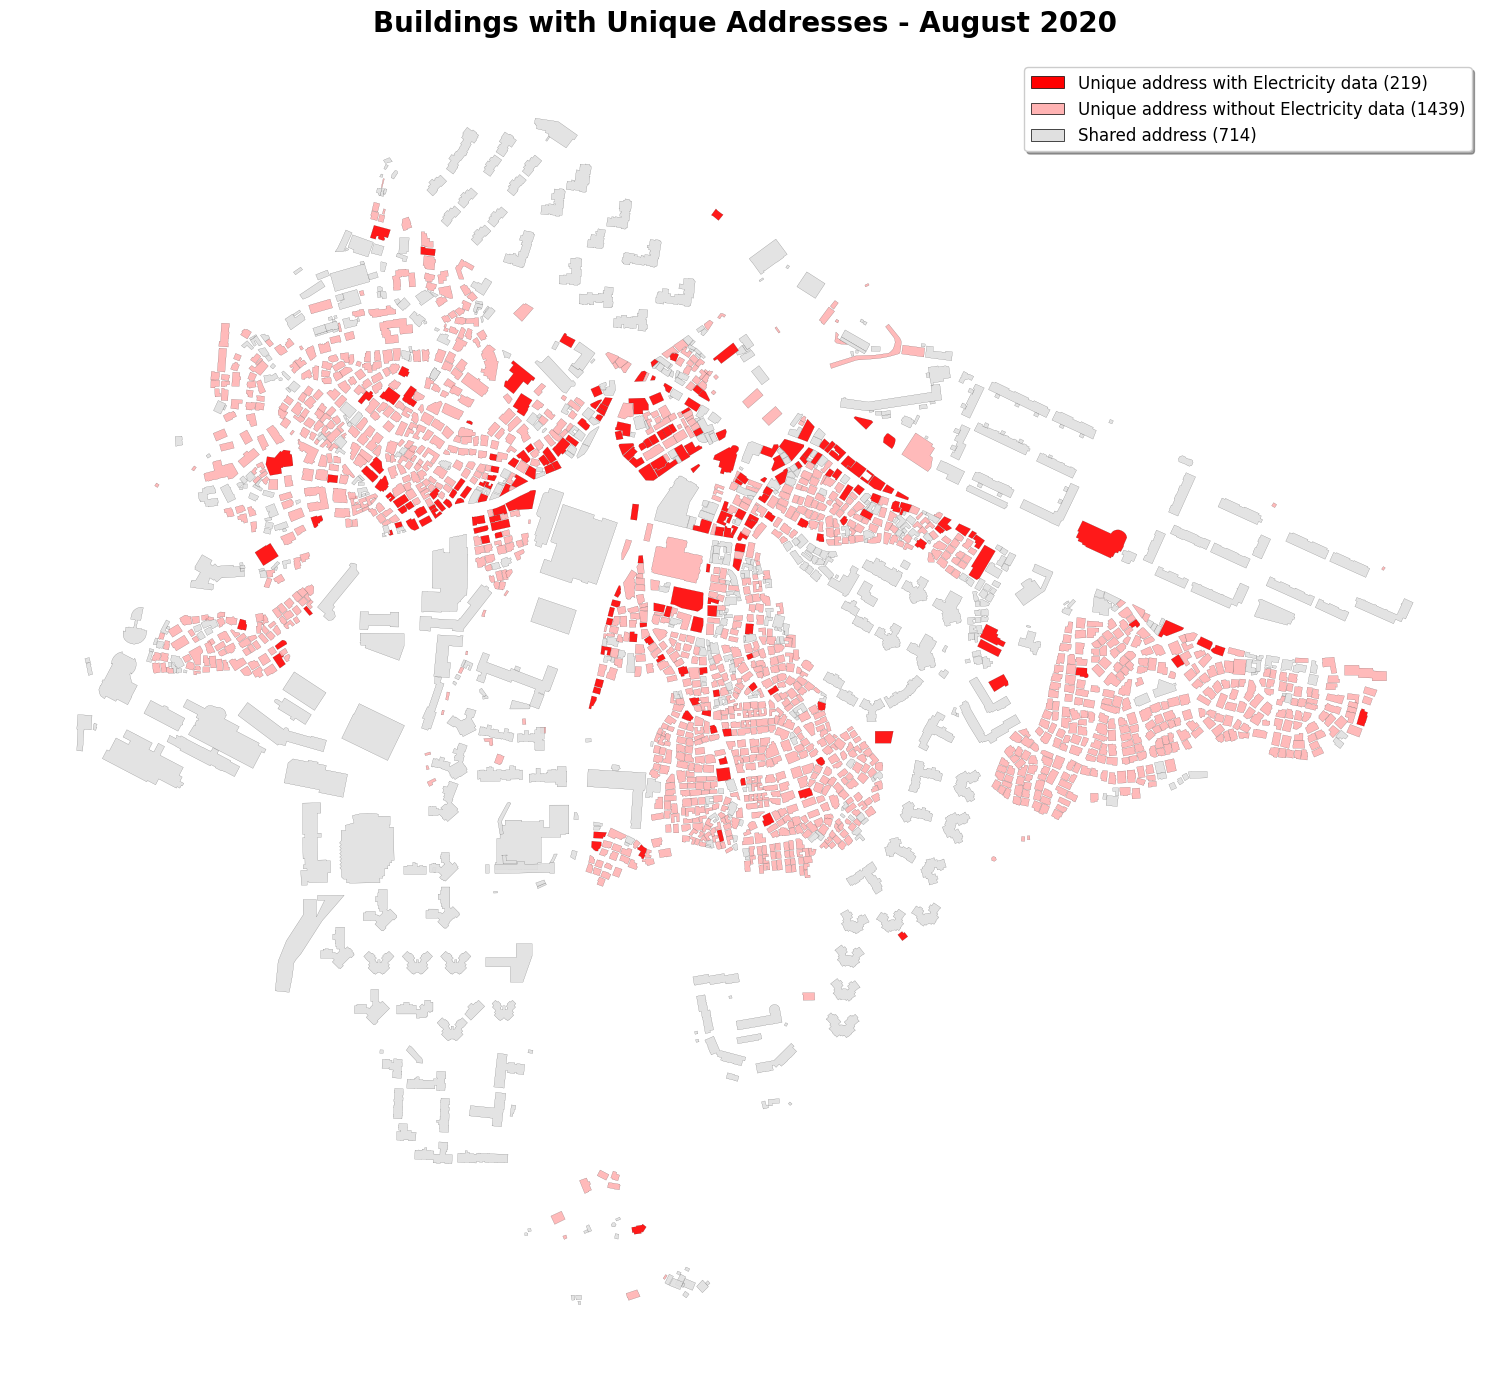

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

def visualize_unique_buildings(shapefile_path, energy_excel_path, year, month, output_path=None):
    """
    Visualize buildings with unique addresses that have energy data for a specific month
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile for the year
    energy_excel_path : str
        Path to the energy consumption Excel file
    year : int
        Year to visualize (e.g., 2020)
    month : int
        Month to visualize (e.g., 8 for August)
    output_path : str, optional
        Path to save the figure
    """
    
    print(f"Creating visualization for {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Identify buildings with unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    
    # Create a column to mark unique address buildings
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load energy data
    print(f"Loading energy data...")
    energy_df = pd.read_excel(energy_excel_path)
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
    print(f"Energy records for {year}-{month:02d}: {len(month_energy)}")
    
    # Get addresses with energy data
    energy_addresses = set(month_energy['address_key'].unique())
    
    # Mark buildings that have energy data
    buildings_gdf['has_energy'] = buildings_gdf['Street num'].isin(energy_addresses)
    
    # Create categories for visualization
    buildings_gdf['category'] = 'Other buildings'
    buildings_gdf.loc[buildings_gdf['is_unique'] & buildings_gdf['has_energy'], 'category'] = 'Unique address with Electricity data'
    buildings_gdf.loc[buildings_gdf['is_unique'] & ~buildings_gdf['has_energy'], 'category'] = 'Unique address without Electricity data'
    buildings_gdf.loc[~buildings_gdf['is_unique'], 'category'] = 'Shared address'
    
    # Count statistics
    print("\nBuilding Statistics:")
    print(buildings_gdf['category'].value_counts())
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    # Define colors
    colors = {
        'Unique address with Electricity data': '#FF0000',  # Red
        'Unique address without Electricity data': '#FFB3B3',  # Light red
        'Shared address': '#E0E0E0',  # Light gray
        'Other buildings': '#C0C0C0'  # Gray
    }
    
    # Plot each category
    for category, color in colors.items():
        buildings_subset = buildings_gdf[buildings_gdf['category'] == category]
        if len(buildings_subset) > 0:
            buildings_subset.plot(ax=ax, 
                                color=color, 
                                edgecolor='black', 
                                linewidth=0.1,
                                alpha=0.9)
    
    # Add title and labels
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'Buildings with Unique Addresses - {month_names[month-1]} {year}', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Create legend
    legend_elements = [
        Patch(facecolor='#FF0000', edgecolor='black', linewidth=0.5,
              label=f'Unique address with Electricity data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address with Electricity data"])})'),
        Patch(facecolor='#FFB3B3', edgecolor='black', linewidth=0.5,
              label=f'Unique address without Electricity data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address without Electricity data"])})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'Shared address ({len(buildings_gdf[buildings_gdf["category"] == "Shared address"])})')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    # Add scale bar (optional)
    # You can add a scale bar here if needed
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_comparison_visualization(shapefile_dir, energy_excel_path, year, months, output_dir=None):
    """
    Create comparison visualizations for multiple months
    
    Parameters:
    -----------
    shapefile_dir : str
        Directory containing yearly shapefiles
    energy_excel_path : str
        Path to the energy consumption Excel file
    year : int
        Year to visualize
    months : list
        List of months to compare (e.g., [1, 4, 7, 10] for quarterly)
    output_dir : str, optional
        Directory to save figures
    """
    
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Load shapefile once
    shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
    buildings_gdf = gpd.read_file(shapefile_path)
    
    # Identify unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load all energy data
    energy_df = pd.read_excel(energy_excel_path)
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for the specific year
    year_energy = energy_df[energy_df['year'] == year]
    
    for idx, month in enumerate(months[:4]):  # Max 4 subplots
        ax = axes[idx]
        
        # Get energy data for this month
        month_energy = year_energy[year_energy['month'] == month]
        energy_addresses = set(month_energy['address_key'].unique())
        
        # Create categories
        buildings_gdf['has_energy'] = buildings_gdf['Street num'].isin(energy_addresses)
        
        # Plot all buildings in gray
        buildings_gdf.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        # Overlay unique address buildings with energy data in red
        unique_with_energy = buildings_gdf[buildings_gdf['is_unique'] & buildings_gdf['has_energy']]
        if len(unique_with_energy) > 0:
            unique_with_energy.plot(ax=ax, color='#FF0000', edgecolor='black', linewidth=0.2)
        
        # Set title
        ax.set_title(f'{month_names[month-1]} {year}\n({len(unique_with_energy)} buildings)', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'Buildings with Unique Addresses and Energy Data - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'unique_buildings_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

# Example usage for August 2020
if __name__ == "__main__":
    # Set your paths
    shapefile_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    energy_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/전기에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/unique_buildings_august_2020.png"
    
    # Create visualization for August 2020
    buildings_data = visualize_unique_buildings(
        shapefile_path,
        energy_excel,
        year=2020,
        month=8,  # August
        output_path=output_path
    )
    
    # Optional: Create comparison across multiple months
    # shapefile_dir = "path/to/shapefiles"
    # create_comparison_visualization(
    #     shapefile_dir,
    #     energy_excel,
    #     year=2020,
    #     months=[1, 4, 7, 10],  # Quarterly comparison
    #     output_dir="path/to/output"
    # )

## Gas

GAS CONSUMPTION ANALYSIS

Step 1: Loading gas consumption data...
Loaded 76889 gas consumption records

Step 2: Processing gas data by year...
Years in gas data: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

--------------------------------------------------
Processing year 2011...
Skipping year 2011

--------------------------------------------------
Processing year 2012...
Skipping year 2012

--------------------------------------------------
Processing year 2013...
Skipping year 2013

--------------------------------------------------
Processing year 2014...
Skipping year 2014

--------------------------------------------------
Processing year 2015...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp
Total buildings: 3399
Buildings with unique addresses: 2449
Buildings with shared addresses: 950

--------------------------------------------------
Processing year 2016...
Loading sh

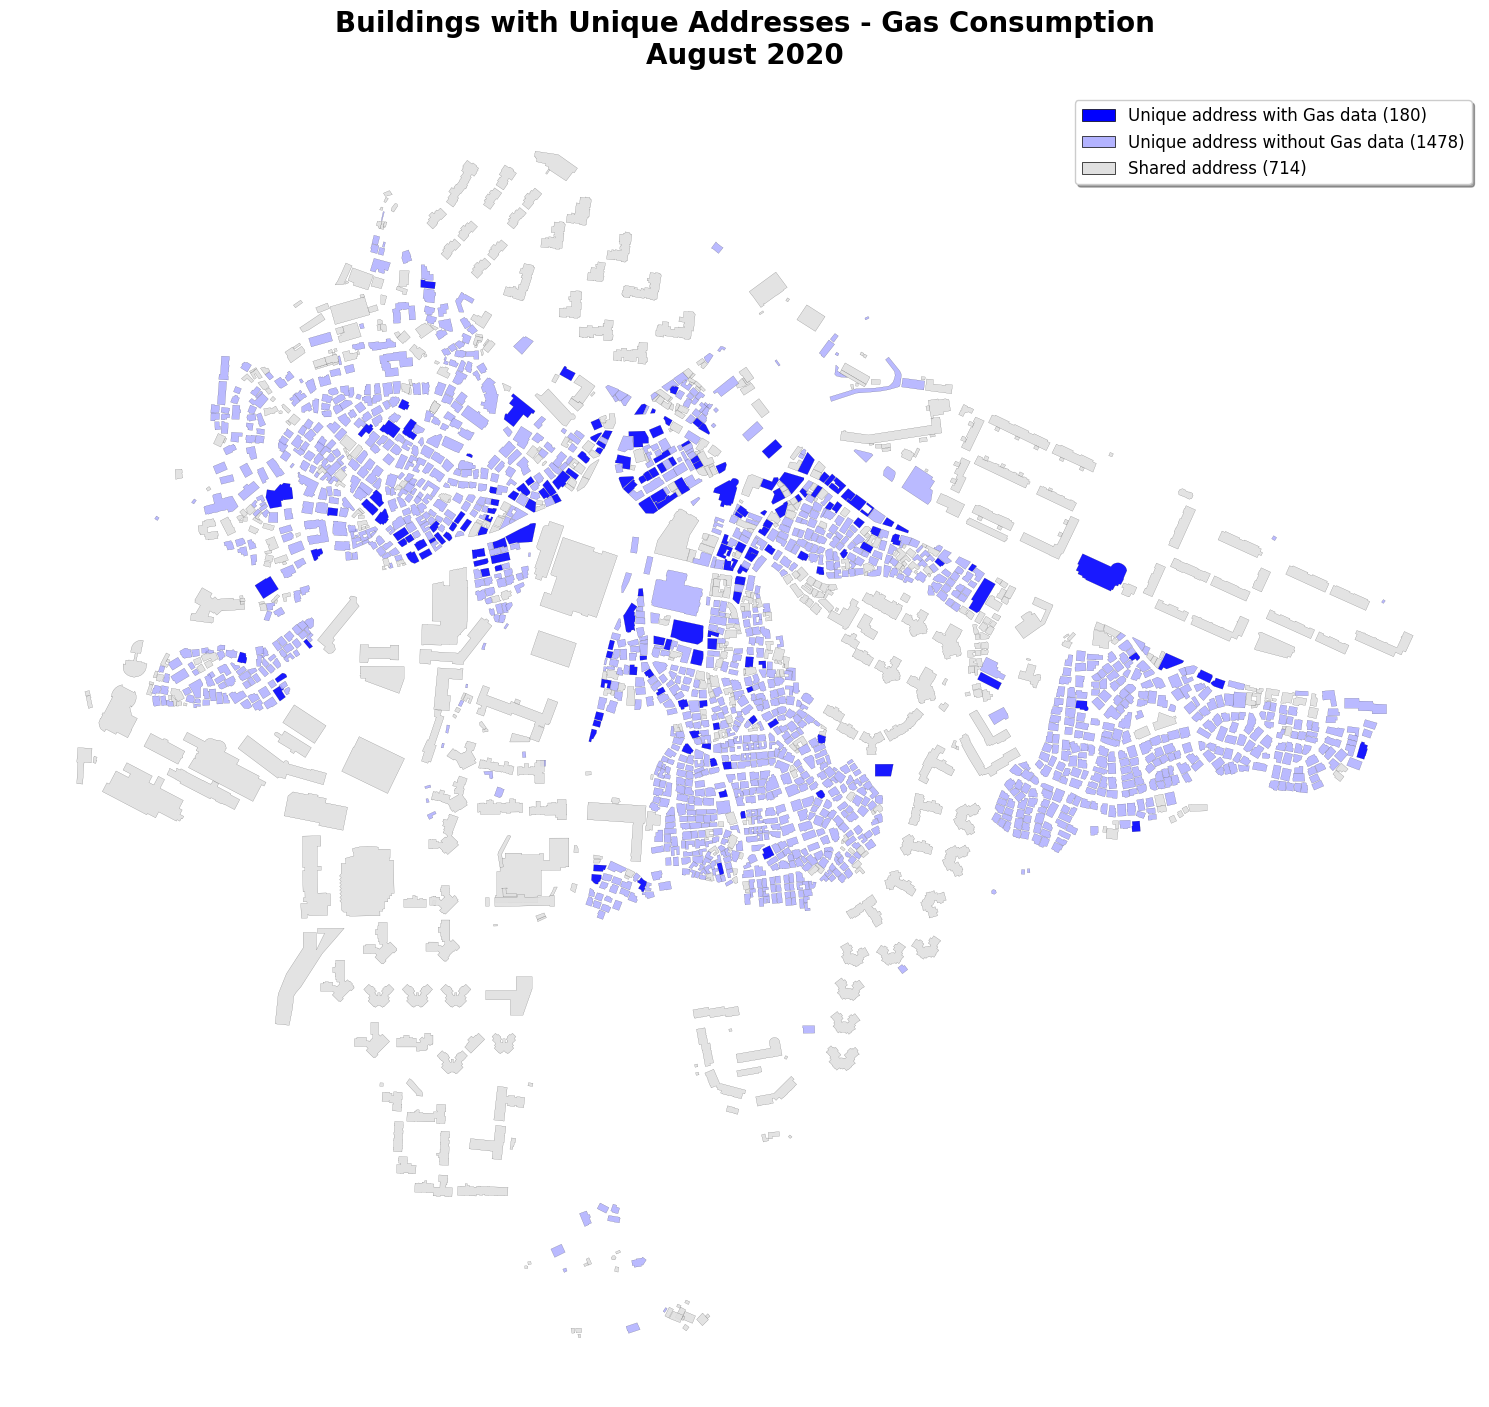

In [41]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime

# ========== PART 1: GAS ENERGY MATCHING AND EUI CALCULATION ==========

def identify_unique_address_buildings(buildings_gdf):
    """
    Identify buildings with unique addresses (not shared with other buildings)
    """
    # Count occurrences of each address
    address_counts = buildings_gdf['Street num'].value_counts()
    
    # Find addresses that appear only once
    unique_addresses = address_counts[address_counts == 1].index
    
    # Filter buildings to keep only unique addresses
    unique_buildings = buildings_gdf[buildings_gdf['Street num'].isin(unique_addresses)].copy()
    
    print(f"Total buildings: {len(buildings_gdf)}")
    print(f"Buildings with unique addresses: {len(unique_buildings)}")
    print(f"Buildings with shared addresses: {len(buildings_gdf) - len(unique_buildings)}")
    
    return unique_buildings

def calculate_gas_eui_for_buildings(shapefile_dir, gas_excel_path, output_path=None):
    """
    Match gas energy data to buildings and calculate EUI for unique-address buildings
    """
    print("\nStep 1: Loading gas consumption data...")
    energy_df = pd.read_excel(gas_excel_path)
    print(f"Loaded {len(energy_df)} gas consumption records")
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    print("\nStep 2: Processing gas data by year...")
    all_matched_data = []
    
    # Get unique years in energy data
    years = sorted(energy_df['year'].unique())
    print(f"Years in gas data: {years}")
    
    for year in years:
        print(f"\n" + "-"*50)
        print(f"Processing year {year}...")
        
        # Find corresponding shapefile
        shapefile_name = f"Shapefile_{year}.shp"
        shapefile_path = os.path.join(shapefile_dir, shapefile_name)
        
        # Check if shapefile exists
        if not os.path.exists(shapefile_path):
            print(f"WARNING: Shapefile not found: {shapefile_path}")
            print(f"Skipping year {year}")
            continue
        
        # Load shapefile for this specific year
        print(f"Loading shapefile: {shapefile_path}")
        year_buildings = gpd.read_file(shapefile_path)
        
        # Get only buildings with unique addresses for this year
        year_unique_buildings = identify_unique_address_buildings(year_buildings)
        
        # Filter energy data for this year
        year_energy = energy_df[energy_df['year'] == year]
        
        # Match with buildings
        matched = year_unique_buildings.merge(
            year_energy,
            left_on='Street num',
            right_on='address_key',
            how='inner'
        )
        
        # Calculate EUI if GFA column exists
        if 'GFA (m2)' in matched.columns:
            # Calculate EUI (kWh/m²)
            matched['EUI_gas'] = matched['사용량(KWh)'] / matched['GFA (m2)']
            matched['EUI_gas'] = matched['EUI_gas'].round(2)
        else:
            print("Warning: GFA (m2) column not found in shapefile. EUI calculation skipped.")
            print(f"Available columns: {list(matched.columns)}")
        
        all_matched_data.append(matched)
    
    # Combine all matched data
    if all_matched_data:
        final_matched = pd.concat(all_matched_data, ignore_index=True)
    else:
        final_matched = gpd.GeoDataFrame()
    
    print(f"\nTotal matched gas records: {len(final_matched)}")
    
    # Create summary table (years as rows, months as columns)
    print(f"\nStep 3: Creating gas consumption summary table...")
    
    if len(final_matched) > 0:
        # Count unique buildings per year-month
        summary = final_matched.groupby(['year', 'month'])['Street num'].nunique().reset_index()
        summary.columns = ['year', 'month', 'building_count']
        
        # Pivot to create the desired table format
        summary_table = summary.pivot(index='year', columns='month', values='building_count')
        summary_table = summary_table.fillna(0).astype(int)
        
        # Add month names as column headers
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        summary_table.columns = [month_names[i-1] for i in summary_table.columns]
        
        # Add total column
        summary_table['Total'] = summary_table.sum(axis=1)
        
        print("\nBuilding Count Summary (Unique Address Buildings with Gas Data):")
        print(summary_table)
    else:
        summary_table = pd.DataFrame()
    
    # Save results if output path provided
    if output_path and len(final_matched) > 0:
        # Save matched data with EUI
        output_base = output_path.rsplit('.', 1)[0]
        
        # Try to save as GeoPackage first (better Unicode support)
        try:
            final_matched.to_file(f"{output_base}_gas_with_eui.gpkg", driver='GPKG')
            print(f"Saved as GeoPackage: {output_base}_gas_with_eui.gpkg")
        except:
            # Save shapefile with English column names
            print("Unicode error saving shapefile. Saving with English column names...")
            final_matched_eng = final_matched.copy()
            column_mapping = {
                '사용년월': 'usage_period',
                '사용량(KWh)': 'usage_kwh',
                '번': 'bun',
                '지': 'ji'
            }
            for kor, eng in column_mapping.items():
                if kor in final_matched_eng.columns:
                    final_matched_eng = final_matched_eng.rename(columns={kor: eng})
            final_matched_eng.to_file(f"{output_base}_gas_with_eui.shp")
        
        # Save summary table
        summary_table.to_csv(f"{output_base}_gas_summary.csv", encoding='utf-8-sig')
        
        # Save detailed CSV with all data
        csv_columns = ['Street num', 'year', 'month', '사용량(KWh)', 'GFA (m2)', 'EUI_gas'] 
        csv_columns = [col for col in csv_columns if col in final_matched.columns]
        final_matched[csv_columns].to_csv(f"{output_base}_gas_detailed.csv", index=False, encoding='utf-8-sig')
        
        print(f"\nResults saved to:")
        print(f"- {output_base}_gas_with_eui.gpkg (or .shp)")
        print(f"- {output_base}_gas_summary.csv")
        print(f"- {output_base}_gas_detailed.csv")
    
    return final_matched, summary_table

def analyze_gas_eui_statistics(matched_data):
    """
    Analyze gas EUI statistics by year and month
    """
    if 'EUI_gas' not in matched_data.columns or len(matched_data) == 0:
        print("No gas EUI data available for analysis")
        return
    
    print("\n" + "="*60)
    print("GAS EUI STATISTICS ANALYSIS")
    print("="*60)
    
    # Overall statistics
    print("\nOverall Gas EUI Statistics:")
    print(f"Mean EUI: {matched_data['EUI_gas'].mean():.2f} kWh/m²")
    print(f"Median EUI: {matched_data['EUI_gas'].median():.2f} kWh/m²")
    print(f"Std Dev: {matched_data['EUI_gas'].std():.2f} kWh/m²")
    print(f"Min EUI: {matched_data['EUI_gas'].min():.2f} kWh/m²")
    print(f"Max EUI: {matched_data['EUI_gas'].max():.2f} kWh/m²")
    
    # Yearly statistics
    print("\nYearly Average Gas EUI:")
    yearly_eui = matched_data.groupby('year')['EUI_gas'].agg(['mean', 'median', 'count'])
    yearly_eui.columns = ['Mean EUI', 'Median EUI', 'Building Count']
    print(yearly_eui.round(2))
    
    # Monthly patterns
    print("\nMonthly Average Gas EUI (across all years):")
    monthly_eui = matched_data.groupby('month')['EUI_gas'].mean().round(2)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_eui.index = [month_names[i-1] for i in monthly_eui.index]
    print(monthly_eui)

# ========== PART 2: GAS CONSUMPTION VISUALIZATION ==========

def visualize_gas_unique_buildings(shapefile_path, gas_excel_path, year, month, output_path=None):
    """
    Visualize buildings with unique addresses that have gas data for a specific month
    Uses BLUE color scheme instead of red
    """
    print(f"Creating gas consumption visualization for {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Identify buildings with unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    
    # Create a column to mark unique address buildings
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load gas data
    print(f"Loading gas consumption data...")
    gas_df = pd.read_excel(gas_excel_path)
    
    # Create address key for matching
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
    print(f"Gas records for {year}-{month:02d}: {len(month_gas)}")
    
    # Get addresses with gas data
    gas_addresses = set(month_gas['address_key'].unique())
    
    # Mark buildings that have gas data
    buildings_gdf['has_gas'] = buildings_gdf['Street num'].isin(gas_addresses)
    
    # Create categories for visualization
    buildings_gdf['category'] = 'Other buildings'
    buildings_gdf.loc[buildings_gdf['is_unique'] & buildings_gdf['has_gas'], 'category'] = 'Unique address with Gas data'
    buildings_gdf.loc[buildings_gdf['is_unique'] & ~buildings_gdf['has_gas'], 'category'] = 'Unique address without Gas data'
    buildings_gdf.loc[~buildings_gdf['is_unique'], 'category'] = 'Shared address'
    
    # Count statistics
    print("\nBuilding Statistics (Gas):")
    print(buildings_gdf['category'].value_counts())
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    # Define colors (BLUE scheme instead of RED)
    colors = {
        'Unique address with Gas data': '#0000FF',  # Blue
        'Unique address without Gas data': '#B3B3FF',  # Light blue
        'Shared address': '#E0E0E0',  # Light gray
        'Other buildings': '#C0C0C0'  # Gray
    }
    
    # Plot each category
    for category, color in colors.items():
        buildings_subset = buildings_gdf[buildings_gdf['category'] == category]
        if len(buildings_subset) > 0:
            buildings_subset.plot(ax=ax, 
                                color=color, 
                                edgecolor='black', 
                                linewidth=0.1,
                                alpha=0.9)
    
    # Add title and labels
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'Buildings with Unique Addresses - Gas Consumption\n{month_names[month-1]} {year}', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Create legend
    legend_elements = [
        Patch(facecolor='#0000FF', edgecolor='black', linewidth=0.5,
              label=f'Unique address with Gas data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address with Gas data"])})'),
        Patch(facecolor='#B3B3FF', edgecolor='black', linewidth=0.5,
              label=f'Unique address without Gas data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address without Gas data"])})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'Shared address ({len(buildings_gdf[buildings_gdf["category"] == "Shared address"])})')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_gas_comparison_visualization(shapefile_dir, gas_excel_path, year, months, output_dir=None):
    """
    Create comparison visualizations for multiple months for gas consumption
    Uses BLUE color scheme
    """
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Load shapefile once
    shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
    buildings_gdf = gpd.read_file(shapefile_path)
    
    # Identify unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load all gas data
    gas_df = pd.read_excel(gas_excel_path)
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for the specific year
    year_gas = gas_df[gas_df['year'] == year]
    
    for idx, month in enumerate(months[:4]):  # Max 4 subplots
        ax = axes[idx]
        
        # Get gas data for this month
        month_gas = year_gas[year_gas['month'] == month]
        gas_addresses = set(month_gas['address_key'].unique())
        
        # Create categories
        buildings_gdf['has_gas'] = buildings_gdf['Street num'].isin(gas_addresses)
        
        # Plot all buildings in gray
        buildings_gdf.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        # Overlay unique address buildings with gas data in BLUE
        unique_with_gas = buildings_gdf[buildings_gdf['is_unique'] & buildings_gdf['has_gas']]
        if len(unique_with_gas) > 0:
            unique_with_gas.plot(ax=ax, color='#0000FF', edgecolor='black', linewidth=0.2)
        
        # Set title
        ax.set_title(f'{month_names[month-1]} {year}\n({len(unique_with_gas)} buildings)', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'Buildings with Unique Addresses and Gas Data - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'unique_buildings_gas_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Gas comparison figure saved to: {output_path}")
    
    plt.show()

# ========== EXAMPLE USAGE ==========

if __name__ == "__main__":
    # Set your paths
    shapefile_dir = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile"  # Directory containing all yearly shapefiles
    gas_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/가스에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas"
    
    # PART 1: Run gas consumption analysis
    print("="*60)
    print("GAS CONSUMPTION ANALYSIS")
    print("="*60)
    
    matched_data, summary_table = calculate_gas_eui_for_buildings(
        shapefile_dir,
        gas_excel,
        output_path
    )
    
    # Additional analysis
    if len(matched_data) > 0:
        analyze_gas_eui_statistics(matched_data)
    
    # PART 2: Create visualization for August 2020
    print("\n" + "="*60)
    print("GAS CONSUMPTION VISUALIZATION - AUGUST 2020")
    print("="*60)
    
    shapefile_2020 = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    visualization_output = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas/unique_buildings_gas_august_2020.png"
    
    buildings_data = visualize_gas_unique_buildings(
        shapefile_2020,
        gas_excel,
        year=2020,
        month=8,  # August
        output_path=visualization_output
    )
    
    # Optional: Create quarterly comparison for 2020
    # create_gas_comparison_visualization(
    #     shapefile_dir,
    #     gas_excel,
    #     year=2020,
    #     months=[1, 4, 7, 10],  # Quarterly
    #     output_dir="path/to/output"
    # )

Creating visualization for ALL buildings with electricity data in 2020-08...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp
Total buildings: 2372
Loading electricity data...
Electricity records for 2020-08: 350
Unique addresses with electricity data: 350

Buildings with electricity data: 477
Buildings without electricity data: 1895

Examples of address normalization:
  '4-0' → '4'
  '4-0' → '4'
  '10-0' → '10'
  '10-0' → '10'
  '10-0' → '10'
  - With unique addresses: 224
  - With shared addresses: 253

Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/All buildings with electricity consumption Aug 2020.png


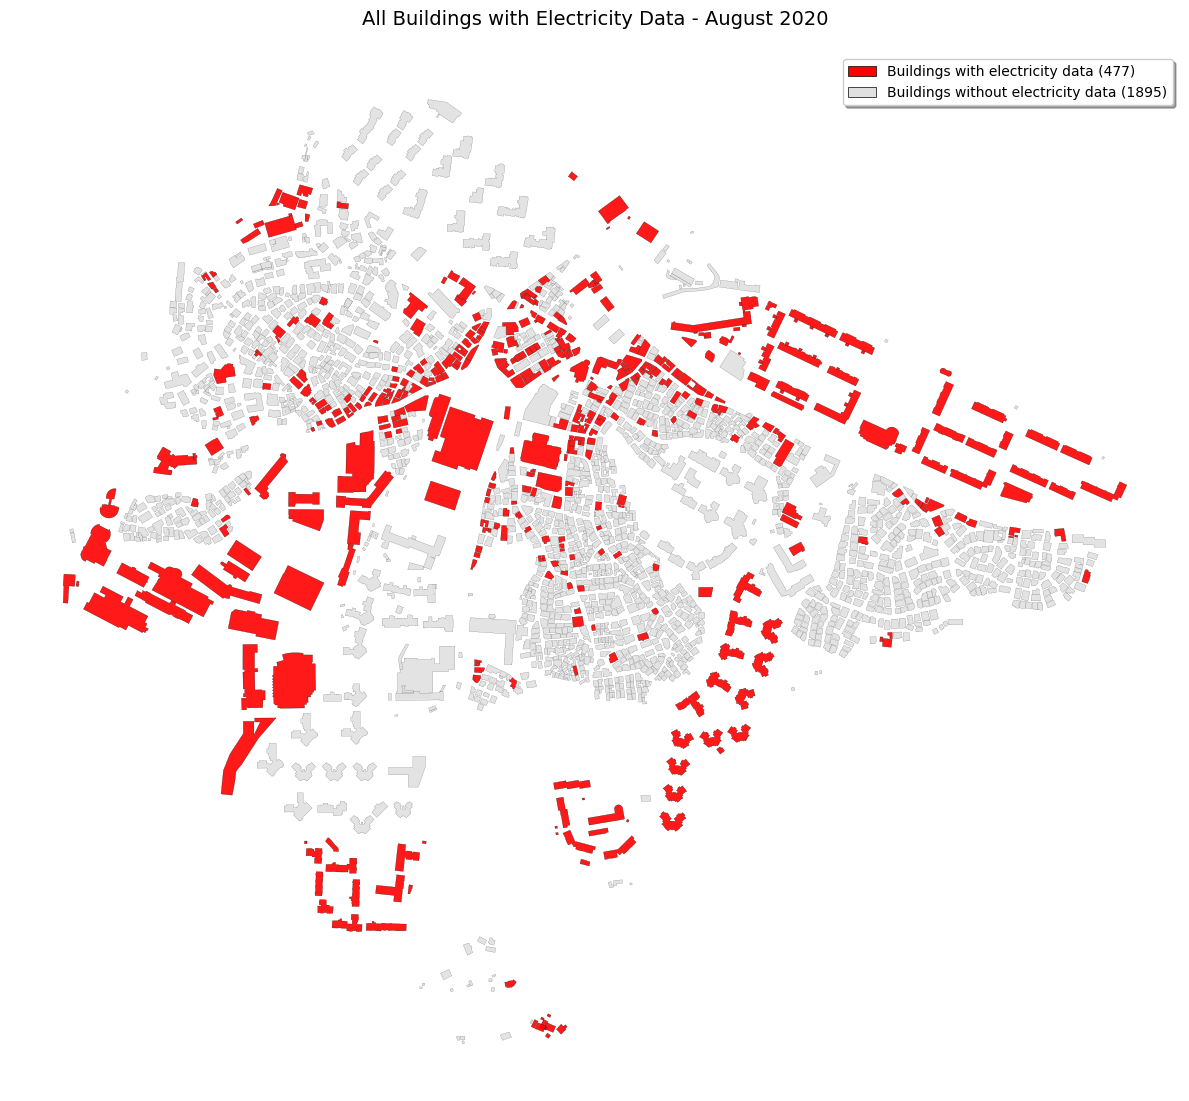

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

def visualize_all_buildings_with_electricity(shapefile_path, electricity_excel_path, year, month, output_path=None):
    """
    Visualize ALL buildings that have electricity data for a specific month
    (including buildings with shared addresses)
    Now with improved matching that handles -0 addresses correctly
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile for the year
    electricity_excel_path : str
        Path to the electricity consumption Excel file
    year : int
        Year to visualize (e.g., 2020)
    month : int
        Month to visualize (e.g., 8 for August)
    output_path : str, optional
        Path to save the figure
    """
    
    print(f"Creating visualization for ALL buildings with electricity data in {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Normalize Street num to handle -0 cases
    buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
        lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
    )
    
    # Load electricity data
    print(f"Loading electricity data...")
    energy_df = pd.read_excel(electricity_excel_path)
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
    print(f"Electricity records for {year}-{month:02d}: {len(month_energy)}")
    
    # Get unique addresses with electricity data
    energy_addresses = set(month_energy['address_key'].unique())
    print(f"Unique addresses with electricity data: {len(energy_addresses)}")
    
    # Mark ALL buildings that have electricity data using normalized addresses
    buildings_gdf['has_electricity'] = buildings_gdf['Street_num_normalized'].isin(energy_addresses)
    
    # Count buildings by category
    buildings_with_electricity = buildings_gdf[buildings_gdf['has_electricity']]
    buildings_without_electricity = buildings_gdf[~buildings_gdf['has_electricity']]
    
    print(f"\nBuildings with electricity data: {len(buildings_with_electricity)}")
    print(f"Buildings without electricity data: {len(buildings_without_electricity)}")
    
    # Show some examples of normalized addresses
    print("\nExamples of address normalization:")
    normalized_examples = buildings_gdf[buildings_gdf['Street num'].astype(str).str.endswith('-0')].head()
    if len(normalized_examples) > 0:
        for idx, row in normalized_examples.iterrows():
            print(f"  '{row['Street num']}' → '{row['Street_num_normalized']}'")
    
    # Check how many are unique vs shared addresses
    address_counts = buildings_gdf['Street_num_normalized'].value_counts()
    unique_addresses_all = address_counts[address_counts == 1].index
    
    buildings_with_elec_unique = buildings_with_electricity[
        buildings_with_electricity['Street_num_normalized'].isin(unique_addresses_all)
    ]
    buildings_with_elec_shared = buildings_with_electricity[
        ~buildings_with_electricity['Street_num_normalized'].isin(unique_addresses_all)
    ]
    
    print(f"  - With unique addresses: {len(buildings_with_elec_unique)}")
    print(f"  - With shared addresses: {len(buildings_with_elec_shared)}")
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot buildings without electricity data (gray background)
    if len(buildings_without_electricity) > 0:
        buildings_without_electricity.plot(ax=ax, 
                                         color='#E0E0E0', 
                                         edgecolor='black', 
                                         linewidth=0.1,
                                         alpha=0.9)
    
    # Plot ALL buildings with electricity data in red
    if len(buildings_with_electricity) > 0:
        buildings_with_electricity.plot(ax=ax, 
                                      color='#FF0000', 
                                      edgecolor='black', 
                                      linewidth=0.2,
                                      alpha=0.9)
    
    # Add title and labels
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'All Buildings with Electricity Data - {month_names[month-1]} {year}', 
                fontsize=14, pad=20)
    
    # Create legend with counts
    legend_elements = [
        Patch(facecolor='#FF0000', edgecolor='black', linewidth=0.5,
              label=f'Buildings with electricity data ({len(buildings_with_electricity)})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'Buildings without electricity data ({len(buildings_without_electricity)})')
    ]

    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_all_buildings_comparison(shapefile_dir, electricity_excel_path, year, months, output_dir=None):
    """
    Create comparison visualizations for multiple months showing all buildings with electricity data
    """
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Load all electricity data once
    energy_df = pd.read_excel(electricity_excel_path)
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    for idx, month in enumerate(months[:4]):  # Max 4 subplots
        ax = axes[idx]
        
        # Load shapefile
        shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
        buildings_gdf = gpd.read_file(shapefile_path)
        
        # Get electricity data for this month
        month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
        energy_addresses = set(month_energy['address_key'].unique())
        
        # Mark buildings with electricity data
        buildings_gdf['has_electricity'] = buildings_gdf['Street num'].isin(energy_addresses)
        
        # Plot all buildings in gray
        buildings_gdf.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        # Overlay buildings with electricity data in red
        buildings_with_elec = buildings_gdf[buildings_gdf['has_electricity']]
        if len(buildings_with_elec) > 0:
            buildings_with_elec.plot(ax=ax, color='#FF0000', edgecolor='black', linewidth=0.2)
        
        # Set title
        ax.set_title(f'{month_names[month-1]} {year}\n({len(buildings_with_elec)} buildings', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'All Buildings with Electricity Data - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'all_buildings_electricity_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

def compare_unique_vs_all_buildings(shapefile_path, electricity_excel_path, year, month, output_path=None):
    """
    Create side-by-side comparison of unique-address-only vs all buildings with electricity
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Load data
    buildings_gdf = gpd.read_file(shapefile_path)
    energy_df = pd.read_excel(electricity_excel_path)
    
    # Process energy data
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
    energy_addresses = set(month_energy['address_key'].unique())
    
    # Identify unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    buildings_gdf['has_electricity'] = buildings_gdf['Street num'].isin(energy_addresses)
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Left plot: Unique addresses only
    buildings_gdf.plot(ax=ax1, color='#E0E0E0', edgecolor='black', linewidth=0.1)
    unique_with_elec = buildings_gdf[buildings_gdf['is_unique'] & buildings_gdf['has_electricity']]
    if len(unique_with_elec) > 0:
        unique_with_elec.plot(ax=ax1, color='#FF0000', edgecolor='black', linewidth=0.2)
    ax1.set_title(f'Unique Address Buildings Only\n{month_names[month-1]} {year}\n({len(unique_with_elec)} buildings)', 
                  fontsize=16, fontweight='bold')
    ax1.set_axis_off()
    
    # Right plot: All buildings
    buildings_gdf.plot(ax=ax2, color='#E0E0E0', edgecolor='black', linewidth=0.1)
    all_with_elec = buildings_gdf[buildings_gdf['has_electricity']]
    if len(all_with_elec) > 0:
        all_with_elec.plot(ax=ax2, color='#FF0000', edgecolor='black', linewidth=0.2)
    ax2.set_title(f'All Buildings with Electricity Data\n{month_names[month-1]} {year}\n({len(all_with_elec)} buildings)', 
                  fontsize=16, fontweight='bold')
    ax2.set_axis_off()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set your paths
    shapefile_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    electricity_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/전기에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/All buildings with electricity consumption Aug 2020.png"
    
    # Create visualization for August 2020 showing ALL buildings with electricity data
    buildings_data = visualize_all_buildings_with_electricity(
        shapefile_path,
        electricity_excel,
        year=2020,
        month=8,  # August
        output_path=output_path
    )
    
    # Optional: Create quarterly comparison
    # shapefile_dir = "path/to/shapefiles"
    # create_all_buildings_comparison(
    #     shapefile_dir,
    #     electricity_excel,
    #     year=2020,
    #     months=[1, 4, 7, 10],  # Quarterly
    #     output_dir="path/to/output"
    # )
    
    # Optional: Compare unique-only vs all buildings
    # compare_output = "path/to/output/unique_vs_all_comparison_august_2020.png"
    # compare_unique_vs_all_buildings(
    #     shapefile_path,
    #     electricity_excel,
    #     year=2020,
    #     month=8,
    #     output_path=compare_output
    # )

GAS CONSUMPTION ANALYSIS

Step 1: Loading gas consumption data...
Loaded 76889 gas consumption records

Step 2: Processing gas data by year...
Years in gas data: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

--------------------------------------------------
Processing year 2011...
Skipping year 2011

--------------------------------------------------
Processing year 2012...
Skipping year 2012

--------------------------------------------------
Processing year 2013...
Skipping year 2013

--------------------------------------------------
Processing year 2014...
Skipping year 2014

--------------------------------------------------
Processing year 2015...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp
Total buildings: 3399
Buildings with unique addresses: 2449
Buildings with shared addresses: 950

--------------------------------------------------
Processing year 2016...
Loading sh

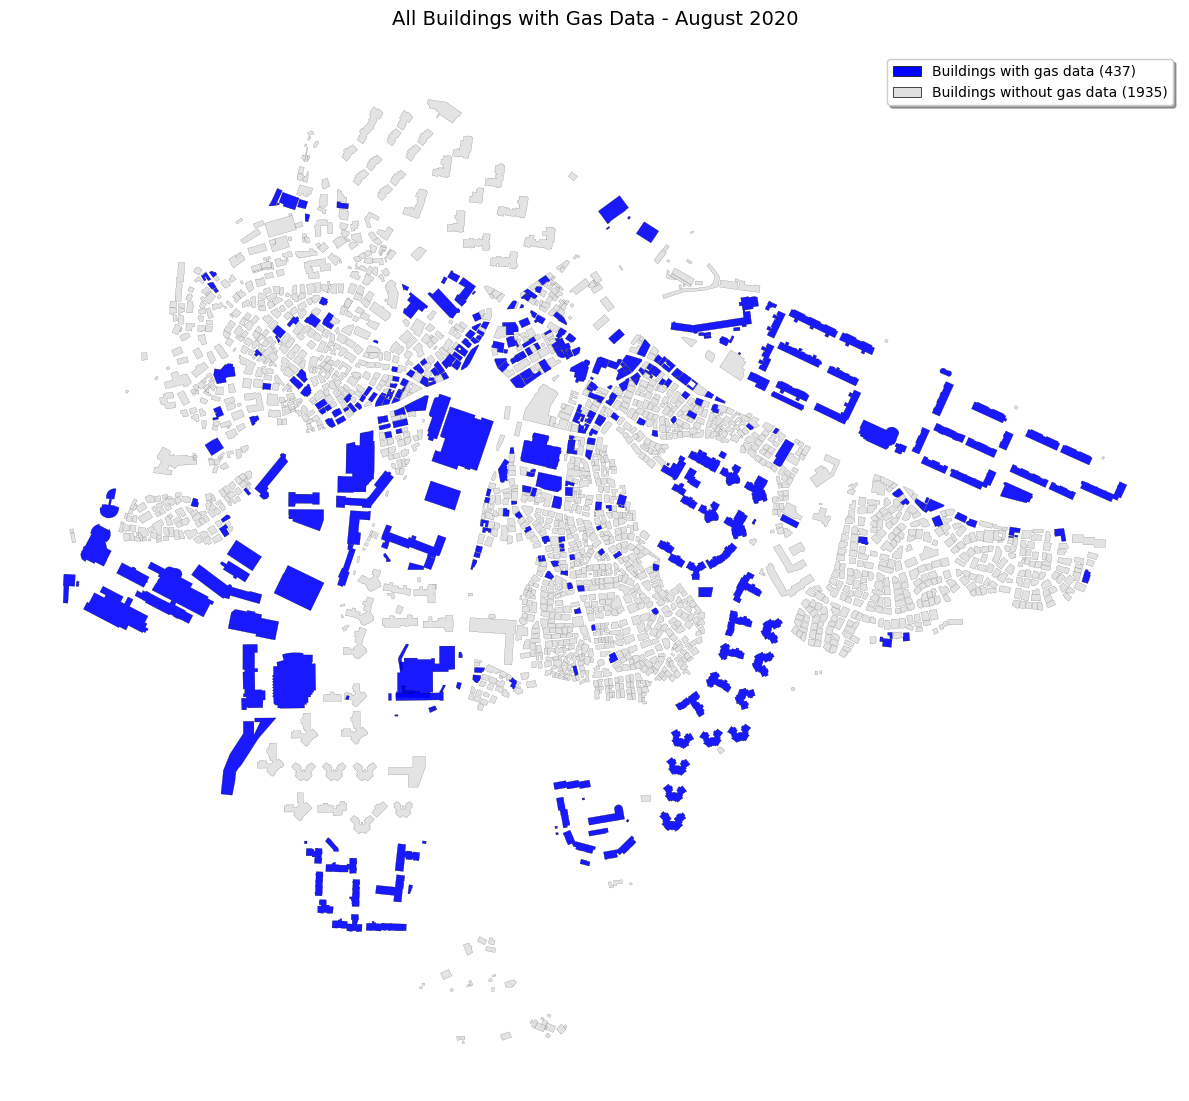

In [33]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime

# ========== PART 1: GAS ENERGY MATCHING AND EUI CALCULATION ==========

def identify_unique_address_buildings(buildings_gdf):
    """
    Identify buildings with unique addresses (not shared with other buildings)
    """
    # Count occurrences of each address
    address_counts = buildings_gdf['Street num'].value_counts()
    
    # Find addresses that appear only once
    unique_addresses = address_counts[address_counts == 1].index
    
    # Filter buildings to keep only unique addresses
    unique_buildings = buildings_gdf[buildings_gdf['Street num'].isin(unique_addresses)].copy()
    
    print(f"Total buildings: {len(buildings_gdf)}")
    print(f"Buildings with unique addresses: {len(unique_buildings)}")
    print(f"Buildings with shared addresses: {len(buildings_gdf) - len(unique_buildings)}")
    
    return unique_buildings

def calculate_gas_eui_for_buildings(shapefile_dir, gas_excel_path, output_path=None):
    """
    Match gas energy data to buildings and calculate EUI for unique-address buildings
    """
    print("\nStep 1: Loading gas consumption data...")
    energy_df = pd.read_excel(gas_excel_path)
    print(f"Loaded {len(energy_df)} gas consumption records")
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    print("\nStep 2: Processing gas data by year...")
    all_matched_data = []
    
    # Get unique years in energy data
    years = sorted(energy_df['year'].unique())
    print(f"Years in gas data: {years}")
    
    for year in years:
        print(f"\n" + "-"*50)
        print(f"Processing year {year}...")
        
        # Find corresponding shapefile
        shapefile_name = f"Shapefile_{year}.shp"
        shapefile_path = os.path.join(shapefile_dir, shapefile_name)
        
        # Check if shapefile exists
        if not os.path.exists(shapefile_path):
            print(f"WARNING: Shapefile not found: {shapefile_path}")
            print(f"Skipping year {year}")
            continue
        
        # Load shapefile for this specific year
        print(f"Loading shapefile: {shapefile_path}")
        year_buildings = gpd.read_file(shapefile_path)
        
        # Get only buildings with unique addresses for this year
        year_unique_buildings = identify_unique_address_buildings(year_buildings)
        
        # Filter energy data for this year
        year_energy = energy_df[energy_df['year'] == year]
        
        # Match with buildings
        matched = year_unique_buildings.merge(
            year_energy,
            left_on='Street num',
            right_on='address_key',
            how='inner'
        )
        
        # Calculate EUI if GFA column exists
        if 'GFA (m2)' in matched.columns:
            # Calculate EUI (kWh/m²)
            matched['EUI_gas'] = matched['사용량(KWh)'] / matched['GFA (m2)']
            matched['EUI_gas'] = matched['EUI_gas'].round(2)
        else:
            print("Warning: GFA (m2) column not found in shapefile. EUI calculation skipped.")
            print(f"Available columns: {list(matched.columns)}")
        
        all_matched_data.append(matched)
    
    # Combine all matched data
    if all_matched_data:
        final_matched = pd.concat(all_matched_data, ignore_index=True)
    else:
        final_matched = gpd.GeoDataFrame()
    
    print(f"\nTotal matched gas records: {len(final_matched)}")
    
    # Create summary table (years as rows, months as columns)
    print(f"\nStep 3: Creating gas consumption summary table...")
    
    if len(final_matched) > 0:
        # Count unique buildings per year-month
        summary = final_matched.groupby(['year', 'month'])['Street num'].nunique().reset_index()
        summary.columns = ['year', 'month', 'building_count']
        
        # Pivot to create the desired table format
        summary_table = summary.pivot(index='year', columns='month', values='building_count')
        summary_table = summary_table.fillna(0).astype(int)
        
        # Add month names as column headers
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        summary_table.columns = [month_names[i-1] for i in summary_table.columns]
        
        # Add total column
        summary_table['Total'] = summary_table.sum(axis=1)
        
        print("\nBuilding Count Summary (Unique Address Buildings with Gas Data):")
        print(summary_table)
    else:
        summary_table = pd.DataFrame()
    
    # Save results if output path provided
    if output_path and len(final_matched) > 0:
        # Save matched data with EUI
        output_base = output_path.rsplit('.', 1)[0]
        
        # Try to save as GeoPackage first (better Unicode support)
        try:
            final_matched.to_file(f"{output_base}_gas_with_eui.gpkg", driver='GPKG')
            print(f"Saved as GeoPackage: {output_base}_gas_with_eui.gpkg")
        except:
            # Save shapefile with English column names
            print("Unicode error saving shapefile. Saving with English column names...")
            final_matched_eng = final_matched.copy()
            column_mapping = {
                '사용년월': 'usage_period',
                '사용량(KWh)': 'usage_kwh',
                '번': 'bun',
                '지': 'ji'
            }
            for kor, eng in column_mapping.items():
                if kor in final_matched_eng.columns:
                    final_matched_eng = final_matched_eng.rename(columns={kor: eng})
            final_matched_eng.to_file(f"{output_base}_gas_with_eui.shp")
        
        # Save summary table
        summary_table.to_csv(f"{output_base}_gas_summary.csv", encoding='utf-8-sig')
        
        # Save detailed CSV with all data
        csv_columns = ['Street num', 'year', 'month', '사용량(KWh)', 'GFA (m2)', 'EUI_gas'] 
        csv_columns = [col for col in csv_columns if col in final_matched.columns]
        final_matched[csv_columns].to_csv(f"{output_base}_gas_detailed.csv", index=False, encoding='utf-8-sig')
        
        print(f"\nResults saved to:")
        print(f"- {output_base}_gas_with_eui.gpkg (or .shp)")
        print(f"- {output_base}_gas_summary.csv")
        print(f"- {output_base}_gas_detailed.csv")
    
    return final_matched, summary_table

def analyze_gas_eui_statistics(matched_data):
    """
    Analyze gas EUI statistics by year and month
    """
    if 'EUI_gas' not in matched_data.columns or len(matched_data) == 0:
        print("No gas EUI data available for analysis")
        return
    
    print("\n" + "="*60)
    print("GAS EUI STATISTICS ANALYSIS")
    print("="*60)
    
    # Overall statistics
    print("\nOverall Gas EUI Statistics:")
    print(f"Mean EUI: {matched_data['EUI_gas'].mean():.2f} kWh/m²")
    print(f"Median EUI: {matched_data['EUI_gas'].median():.2f} kWh/m²")
    print(f"Std Dev: {matched_data['EUI_gas'].std():.2f} kWh/m²")
    print(f"Min EUI: {matched_data['EUI_gas'].min():.2f} kWh/m²")
    print(f"Max EUI: {matched_data['EUI_gas'].max():.2f} kWh/m²")
    
    # Yearly statistics
    print("\nYearly Average Gas EUI:")
    yearly_eui = matched_data.groupby('year')['EUI_gas'].agg(['mean', 'median', 'count'])
    yearly_eui.columns = ['Mean EUI', 'Median EUI', 'Building Count']
    print(yearly_eui.round(2))
    
    # Monthly patterns
    print("\nMonthly Average Gas EUI (across all years):")
    monthly_eui = matched_data.groupby('month')['EUI_gas'].mean().round(2)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_eui.index = [month_names[i-1] for i in monthly_eui.index]
    print(monthly_eui)

# ========== PART 2: GAS CONSUMPTION VISUALIZATION ==========

def visualize_gas_unique_buildings(shapefile_path, gas_excel_path, year, month, output_path=None):
    """
    Visualize buildings with unique addresses that have gas data for a specific month
    Uses BLUE color scheme instead of red
    """
    print(f"Creating gas consumption visualization for {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Identify buildings with unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    
    # Create a column to mark unique address buildings
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load gas data
    print(f"Loading gas consumption data...")
    gas_df = pd.read_excel(gas_excel_path)
    
    # Create address key for matching
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
    print(f"Gas records for {year}-{month:02d}: {len(month_gas)}")
    
    # Get addresses with gas data
    gas_addresses = set(month_gas['address_key'].unique())
    
    # Mark buildings that have gas data
    buildings_gdf['has_gas'] = buildings_gdf['Street num'].isin(gas_addresses)
    
    # Create categories for visualization
    buildings_gdf['category'] = 'Other buildings'
    buildings_gdf.loc[buildings_gdf['is_unique'] & buildings_gdf['has_gas'], 'category'] = 'Unique address with gas data'
    buildings_gdf.loc[buildings_gdf['is_unique'] & ~buildings_gdf['has_gas'], 'category'] = 'Unique address without gas data'
    buildings_gdf.loc[~buildings_gdf['is_unique'], 'category'] = 'Shared address'
    
    # Count statistics
    print("\nBuilding Statistics (Gas):")
    print(buildings_gdf['category'].value_counts())
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Define colors (BLUE scheme instead of RED)
    colors = {
        'Unique address with gas data': '#0000FF',  # Blue
        'Unique address without gas data': '#B3B3FF',  # Light blue
        'Shared address': '#E0E0E0',  # Light gray
        'Other buildings': '#C0C0C0'  # Gray
    }
    
    # Plot each category
    for category, color in colors.items():
        buildings_subset = buildings_gdf[buildings_gdf['category'] == category]
        if len(buildings_subset) > 0:
            buildings_subset.plot(ax=ax, 
                                color=color, 
                                edgecolor='black', 
                                linewidth=0.1,
                                alpha=0.9)
    
    # Add title and labels
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'Buildings with Unique Addresses - Gas Consumption\n{month_names[month-1]} {year}', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Create legend
    legend_elements = [
        Patch(facecolor='#0000FF', edgecolor='black', linewidth=0.5,
              label=f'Unique address with gas data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address with gas data"])})'),
        Patch(facecolor='#B3B3FF', edgecolor='black', linewidth=0.5,
              label=f'Unique address without gas data ({len(buildings_gdf[buildings_gdf["category"] == "Unique address without gas data"])})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'Shared address ({len(buildings_gdf[buildings_gdf["category"] == "Shared address"])})')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_gas_comparison_visualization(shapefile_dir, gas_excel_path, year, months, output_dir=None):
    """
    Create comparison visualizations for multiple months for gas consumption
    Uses BLUE color scheme
    """
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Load shapefile once
    shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
    buildings_gdf = gpd.read_file(shapefile_path)
    
    # Identify unique addresses
    address_counts = buildings_gdf['Street num'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street num'].isin(unique_addresses)
    
    # Load all gas data
    gas_df = pd.read_excel(gas_excel_path)
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for the specific year
    year_gas = gas_df[gas_df['year'] == year]
    
    for idx, month in enumerate(months[:4]):  # Max 4 subplots
        ax = axes[idx]
        
        # Get gas data for this month
        month_gas = year_gas[year_gas['month'] == month]
        gas_addresses = set(month_gas['address_key'].unique())
        
        # Create categories
        buildings_gdf['has_gas'] = buildings_gdf['Street num'].isin(gas_addresses)
        
        # Plot all buildings in gray
        buildings_gdf.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        # Overlay unique address buildings with gas data in BLUE
        unique_with_gas = buildings_gdf[buildings_gdf['is_unique'] & buildings_gdf['has_gas']]
        if len(unique_with_gas) > 0:
            unique_with_gas.plot(ax=ax, color='#0000FF', edgecolor='black', linewidth=0.2)
        
        # Set title
        ax.set_title(f'{month_names[month-1]} {year}\n({len(unique_with_gas)} buildings)', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'Buildings with Unique Addresses and Gas Data - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'unique_buildings_gas_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Gas comparison figure saved to: {output_path}")
    
    plt.show()

def visualize_all_buildings_with_gas(shapefile_path, gas_excel_path, year, month, output_path=None):
    """
    Visualize ALL buildings that have gas data for a specific month
    (including buildings with shared addresses)
    Now with improved matching that handles -0 addresses correctly
    Uses BLUE color scheme
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile for the year
    gas_excel_path : str
        Path to the gas consumption Excel file
    year : int
        Year to visualize (e.g., 2020)
    month : int
        Month to visualize (e.g., 8 for August)
    output_path : str, optional
        Path to save the figure
    """
    
    print(f"Creating visualization for ALL buildings with gas data in {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Normalize Street num to handle -0 cases
    buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
        lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
    )
    
    # Load gas data
    print(f"Loading gas data...")
    gas_df = pd.read_excel(gas_excel_path)
    
    # Create address key for matching
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
    print(f"Gas records for {year}-{month:02d}: {len(month_gas)}")
    
    # Get unique addresses with gas data
    gas_addresses = set(month_gas['address_key'].unique())
    print(f"Unique addresses with gas data: {len(gas_addresses)}")
    
    # Mark ALL buildings that have gas data using normalized addresses
    buildings_gdf['has_gas'] = buildings_gdf['Street_num_normalized'].isin(gas_addresses)
    
    # Count buildings by category
    buildings_with_gas = buildings_gdf[buildings_gdf['has_gas']]
    buildings_without_gas = buildings_gdf[~buildings_gdf['has_gas']]
    
    print(f"\nBuildings with gas data: {len(buildings_with_gas)}")
    print(f"Buildings without gas data: {len(buildings_without_gas)}")
    
    # Show some examples of normalized addresses
    print("\nExamples of address normalization:")
    normalized_examples = buildings_gdf[buildings_gdf['Street num'].astype(str).str.endswith('-0')].head()
    if len(normalized_examples) > 0:
        for idx, row in normalized_examples.iterrows():
            print(f"  '{row['Street num']}' → '{row['Street_num_normalized']}'")
    
    # Check how many are unique vs shared addresses
    address_counts = buildings_gdf['Street_num_normalized'].value_counts()
    unique_addresses_all = address_counts[address_counts == 1].index
    
    buildings_with_gas_unique = buildings_with_gas[
        buildings_with_gas['Street_num_normalized'].isin(unique_addresses_all)
    ]
    buildings_with_gas_shared = buildings_with_gas[
        ~buildings_with_gas['Street_num_normalized'].isin(unique_addresses_all)
    ]
    
    print(f"  - With unique addresses: {len(buildings_with_gas_unique)}")
    print(f"  - With shared addresses: {len(buildings_with_gas_shared)}")
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot buildings without gas data (gray background)
    if len(buildings_without_gas) > 0:
        buildings_without_gas.plot(ax=ax, 
                                 color='#E0E0E0', 
                                 edgecolor='black', 
                                 linewidth=0.1,
                                 alpha=0.9)
    
    # Plot ALL buildings with gas data in BLUE
    if len(buildings_with_gas) > 0:
        buildings_with_gas.plot(ax=ax, 
                              color='#0000FF', 
                              edgecolor='black', 
                              linewidth=0.2,
                              alpha=0.9)
    
    # Add title and labels
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'All Buildings with Gas Data - {month_names[month-1]} {year}', 
                fontsize=14, pad=20)
    
    # Create legend with counts
    legend_elements = [
        Patch(facecolor='#0000FF', edgecolor='black', linewidth=0.5,
              label=f'Buildings with gas data ({len(buildings_with_gas)})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'Buildings without gas data ({len(buildings_without_gas)})')
    ]
    
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

# Add this to the main section at the bottom of the file
if __name__ == "__main__":
    # Set your paths
    shapefile_dir = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile"  # Directory containing all yearly shapefiles
    gas_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/가스에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas"
    
    # PART 1: Run gas consumption analysis
    print("="*60)
    print("GAS CONSUMPTION ANALYSIS")
    print("="*60)
    
    matched_data, summary_table = calculate_gas_eui_for_buildings(
        shapefile_dir,
        gas_excel,
        output_path
    )
    
    # Additional analysis
    if len(matched_data) > 0:
        analyze_gas_eui_statistics(matched_data)
    
    # PART 2: Create visualization for August 2020
    print("\n" + "="*60)
    print("GAS CONSUMPTION VISUALIZATION - AUGUST 2020")
    print("="*60)
    
    shapefile_2020 = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    visualization_output = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas/All buildings with gas consumption Aug 2020.png"


    
    # Use the new function for ALL buildings with gas data
    buildings_data = visualize_all_buildings_with_gas(
        shapefile_2020,
        gas_excel,
        year=2020,
        month=8,  # August
        output_path=visualization_output
    )

Creating electricity visualization with unique vs shared addresses for 2020-08...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp
Total buildings: 2372
Buildings with unique addresses: 1658
Buildings with shared addresses: 714

Loading electricity data...
Electricity records for 2020-08: 350
Unique addresses with electricity data: 350

Building counts by category:
  No electricity: 1895
  Shared with electricity: 253
  Unique with electricity: 224

Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/electricity_unique_shared_august_2020.png


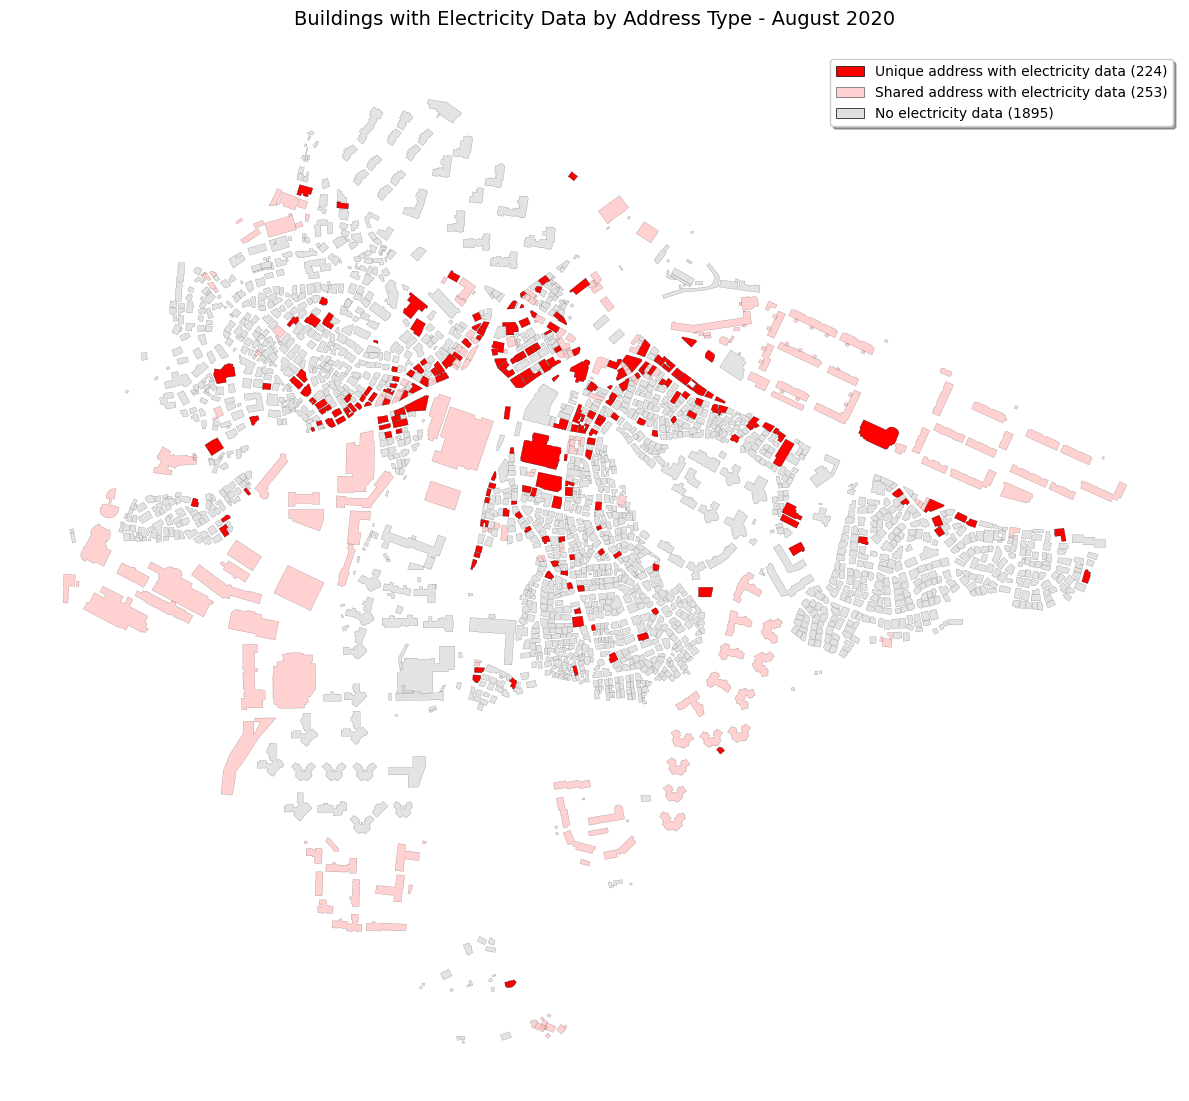

In [79]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

def visualize_electricity_unique_vs_shared(shapefile_path, electricity_excel_path, year, month, output_path=None):
    """
    Visualize buildings with electricity data, distinguishing between unique and shared addresses
    - Unique address buildings with electricity: Red (100% opacity)
    - Shared address buildings with electricity: Red (60% opacity)
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile for the year
    electricity_excel_path : str
        Path to the electricity consumption Excel file
    year : int
        Year to visualize (e.g., 2020)
    month : int
        Month to visualize (e.g., 8 for August)
    output_path : str, optional
        Path to save the figure
    """
    
    print(f"Creating electricity visualization with unique vs shared addresses for {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Normalize Street num to handle -0 cases
    buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
        lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
    )
    
    # Identify unique vs shared addresses
    address_counts = buildings_gdf['Street_num_normalized'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street_num_normalized'].isin(unique_addresses)
    
    print(f"Buildings with unique addresses: {buildings_gdf['is_unique'].sum()}")
    print(f"Buildings with shared addresses: {(~buildings_gdf['is_unique']).sum()}")
    
    # Load electricity data
    print(f"\nLoading electricity data...")
    energy_df = pd.read_excel(electricity_excel_path)
    
    # Create address key for matching
    energy_df['address_key'] = energy_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
    energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
    print(f"Electricity records for {year}-{month:02d}: {len(month_energy)}")
    
    # Get unique addresses with electricity data
    energy_addresses = set(month_energy['address_key'].unique())
    print(f"Unique addresses with electricity data: {len(energy_addresses)}")
    
    # Mark buildings that have electricity data using normalized addresses
    buildings_gdf['has_electricity'] = buildings_gdf['Street_num_normalized'].isin(energy_addresses)
    
    # Create categories
    buildings_gdf['category'] = 'No electricity'
    buildings_gdf.loc[buildings_gdf['has_electricity'] & buildings_gdf['is_unique'], 'category'] = 'Unique with electricity'
    buildings_gdf.loc[buildings_gdf['has_electricity'] & ~buildings_gdf['is_unique'], 'category'] = 'Shared with electricity'
    
    # Count by category
    category_counts = buildings_gdf['category'].value_counts()
    print(f"\nBuilding counts by category:")
    for cat, count in category_counts.items():
        print(f"  {cat}: {count}")
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot in order (bottom to top)
    
    # 1. Buildings without electricity data (gray background)
    no_electricity = buildings_gdf[buildings_gdf['category'] == 'No electricity']
    if len(no_electricity) > 0:
        no_electricity.plot(ax=ax, 
                           color='#E0E0E0', 
                           edgecolor='black', 
                           linewidth=0.1,
                           alpha=0.9)
    
    # 2. Shared address buildings with electricity (red, 60% opacity)
    shared_with_elec = buildings_gdf[buildings_gdf['category'] == 'Shared with electricity']
    if len(shared_with_elec) > 0:
        shared_with_elec.plot(ax=ax, 
                             color='#FFB3B3', 
                             edgecolor='black', 
                             linewidth=0.15,
                             alpha=0.6)  # 60% opacity
    
    # 3. Unique address buildings with electricity (red, 100% opacity)
    unique_with_elec = buildings_gdf[buildings_gdf['category'] == 'Unique with electricity']
    if len(unique_with_elec) > 0:
        unique_with_elec.plot(ax=ax, 
                             color='#FF0000', 
                             edgecolor='black', 
                             linewidth=0.2,
                             alpha=1.0)  # 100% opacity
    
    # Add title
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'Buildings with Electricity Data by Address Type - {month_names[month-1]} {year}', 
                fontsize=14, pad=20)
    
    # Create custom legend with different opacities
    legend_elements = [
        Patch(facecolor='#FF0000', edgecolor='black', linewidth=0.5, alpha=1.0,
              label=f'Unique address with electricity data ({len(unique_with_elec)})'),
        Patch(facecolor='#FFB3B3', edgecolor='black', linewidth=0.5, alpha=0.6,
              label=f'Shared address with electricity data ({len(shared_with_elec)})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'No electricity data ({len(no_electricity)})')
    ]
    
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_comparison_unique_shared(shapefile_dir, electricity_excel_path, year, months, output_dir=None):
    """
    Create comparison visualization for multiple months showing unique vs shared addresses
    """
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 1, figsize=(12, 12))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Process each month
    for idx, month in enumerate(months[:4]):
        ax = axes[idx]
        
        # Load shapefile
        shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
        buildings_gdf = gpd.read_file(shapefile_path)
        
        # Normalize addresses
        buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
            lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
        )
        
        # Identify unique addresses
        address_counts = buildings_gdf['Street_num_normalized'].value_counts()
        unique_addresses = address_counts[address_counts == 1].index
        buildings_gdf['is_unique'] = buildings_gdf['Street_num_normalized'].isin(unique_addresses)
        
        # Load electricity data
        energy_df = pd.read_excel(electricity_excel_path)
        energy_df['address_key'] = energy_df.apply(
            lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
            axis=1
        )
        energy_df['year'] = energy_df['사용년월'].astype(str).str[:4].astype(int)
        energy_df['month'] = energy_df['사용년월'].astype(str).str[4:6].astype(int)
        
        # Filter for specific month
        month_energy = energy_df[(energy_df['year'] == year) & (energy_df['month'] == month)]
        energy_addresses = set(month_energy['address_key'].unique())
        
        # Mark buildings with electricity
        buildings_gdf['has_electricity'] = buildings_gdf['Street_num_normalized'].isin(energy_addresses)
        
        # Create categories
        buildings_gdf['category'] = 'No electricity'
        buildings_gdf.loc[buildings_gdf['has_electricity'] & buildings_gdf['is_unique'], 'category'] = 'Unique with electricity'
        buildings_gdf.loc[buildings_gdf['has_electricity'] & ~buildings_gdf['is_unique'], 'category'] = 'Shared with electricity'
        
        # Plot
        no_elec = buildings_gdf[buildings_gdf['category'] == 'No electricity']
        shared_elec = buildings_gdf[buildings_gdf['category'] == 'Shared with electricity']
        unique_elec = buildings_gdf[buildings_gdf['category'] == 'Unique with electricity']
        
        if len(no_elec) > 0:
            no_elec.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        if len(shared_elec) > 0:
            shared_elec.plot(ax=ax, color='#FFB3B3', edgecolor='black', linewidth=0.15, alpha=0.05)
        
        if len(unique_elec) > 0:
            unique_elec.plot(ax=ax, color='#FF0000', edgecolor='black', linewidth=0.2, alpha=1.0)
        
        # Set title
        total_with_elec = len(unique_elec) + len(shared_elec)
        ax.set_title(f'{month_names[month-1]} {year}\n' +
                    f'Unique: {len(unique_elec)}, Shared: {len(shared_elec)}, Total: {total_with_elec}', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'Electricity Data Coverage by Address Type - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'electricity_unique_shared_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set your paths
    shapefile_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    electricity_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/전기에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Electricity/electricity_unique_shared_august_2020.png"

    
    # Create visualization for August 2020
    buildings_data = visualize_electricity_unique_vs_shared(
        shapefile_path,
        electricity_excel,
        year=2020,
        month=8,  # August
        output_path=output_path
    )
    
    # Optional: Create quarterly comparison
    # shapefile_dir = "path/to/shapefiles"
    # create_comparison_unique_shared(
    #     shapefile_dir,
    #     electricity_excel,
    #     year=2020,
    #     months=[1, 4, 7, 10],  # Quarterly
    #     output_dir="path/to/output"
    # )

Creating gas visualization with unique vs shared addresses for 2020-08...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp
Total buildings: 2372
Buildings with unique addresses: 1658
Buildings with shared addresses: 714

Loading gas data...
Gas records for 2020-08: 261
Unique addresses with gas data: 260

Building counts by category:
  No gas: 1935
  Shared with gas: 252
  Unique with gas: 185

Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas/gas_unique_shared_august_2020.png


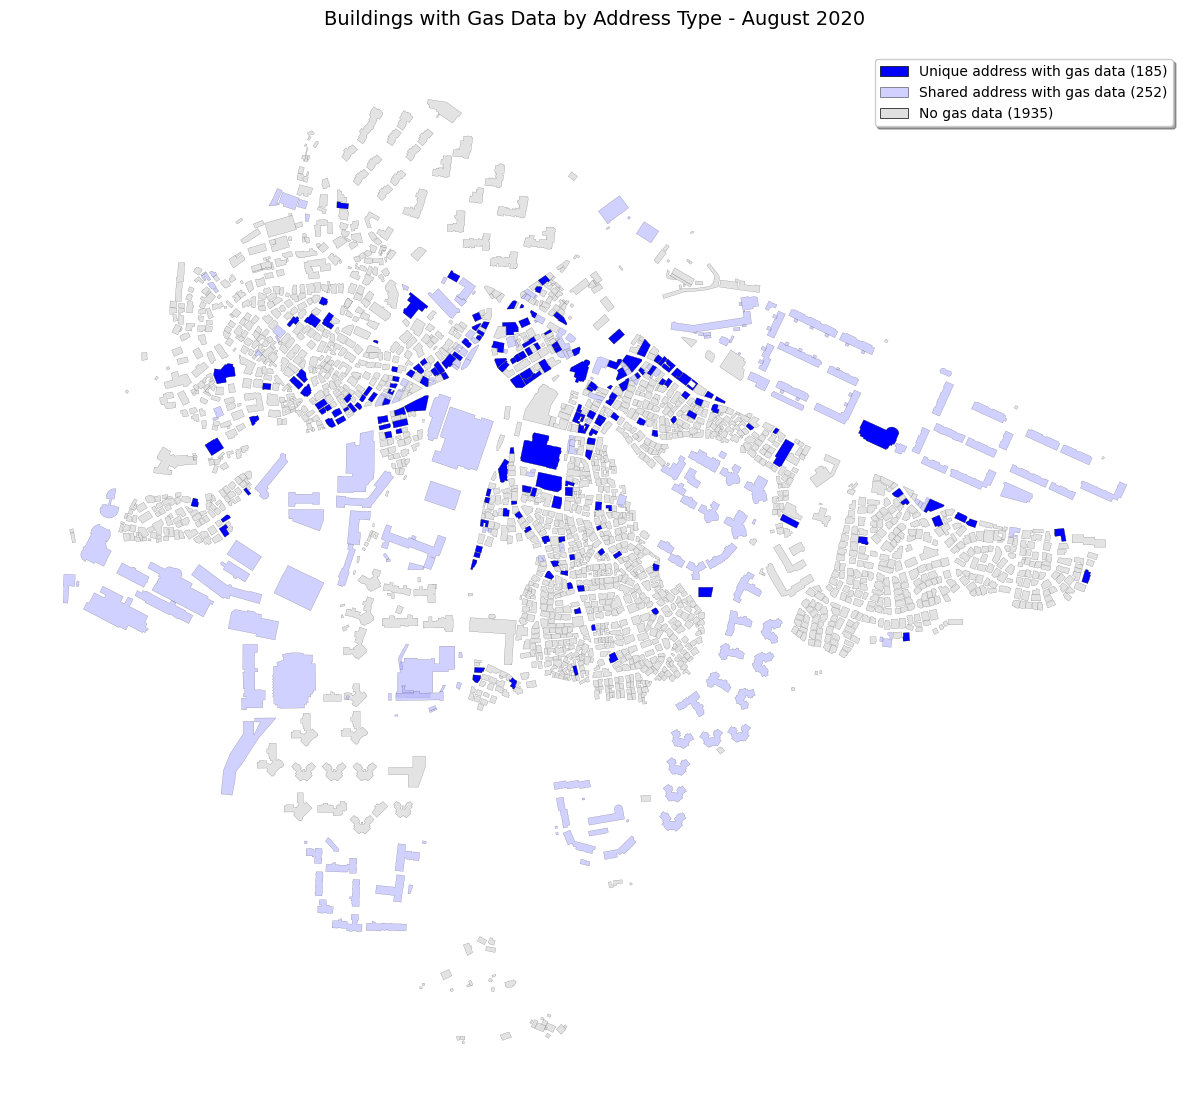

In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

def visualize_gas_unique_vs_shared(shapefile_path, gas_excel_path, year, month, output_path=None):
    """
    Visualize buildings with gas data, distinguishing between unique and shared addresses
    - Unique address buildings with gas: Blue (100% opacity)
    - Shared address buildings with gas: Blue (60% opacity)
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile for the year
    gas_excel_path : str
        Path to the gas consumption Excel file
    year : int
        Year to visualize (e.g., 2020)
    month : int
        Month to visualize (e.g., 8 for August)
    output_path : str, optional
        Path to save the figure
    """
    
    print(f"Creating gas visualization with unique vs shared addresses for {year}-{month:02d}...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Normalize Street num to handle -0 cases
    buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
        lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
    )
    
    # Identify unique vs shared addresses
    address_counts = buildings_gdf['Street_num_normalized'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street_num_normalized'].isin(unique_addresses)
    
    print(f"Buildings with unique addresses: {buildings_gdf['is_unique'].sum()}")
    print(f"Buildings with shared addresses: {(~buildings_gdf['is_unique']).sum()}")
    
    # Load gas data
    print(f"\nLoading gas data...")
    gas_df = pd.read_excel(gas_excel_path)
    
    # Create address key for matching
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    
    # Extract year and month from 사용년월
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    
    # Filter for specific year and month
    month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
    print(f"Gas records for {year}-{month:02d}: {len(month_gas)}")
    
    # Get unique addresses with gas data
    gas_addresses = set(month_gas['address_key'].unique())
    print(f"Unique addresses with gas data: {len(gas_addresses)}")
    
    # Mark buildings that have gas data using normalized addresses
    buildings_gdf['has_gas'] = buildings_gdf['Street_num_normalized'].isin(gas_addresses)
    
    # Create categories
    buildings_gdf['category'] = 'No gas'
    buildings_gdf.loc[buildings_gdf['has_gas'] & buildings_gdf['is_unique'], 'category'] = 'Unique with gas'
    buildings_gdf.loc[buildings_gdf['has_gas'] & ~buildings_gdf['is_unique'], 'category'] = 'Shared with gas'
    
    # Count by category
    category_counts = buildings_gdf['category'].value_counts()
    print(f"\nBuilding counts by category:")
    for cat, count in category_counts.items():
        print(f"  {cat}: {count}")
    
    # Create the visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot in order (bottom to top)
    
    # 1. Buildings without gas data (gray background)
    no_gas = buildings_gdf[buildings_gdf['category'] == 'No gas']
    if len(no_gas) > 0:
        no_gas.plot(ax=ax, 
                   color='#E0E0E0', 
                   edgecolor='black', 
                   linewidth=0.1,
                   alpha=0.9)
    
    # 2. Shared address buildings with gas (blue, 60% opacity)
    shared_with_gas = buildings_gdf[buildings_gdf['category'] == 'Shared with gas']
    if len(shared_with_gas) > 0:
        shared_with_gas.plot(ax=ax, 
                            color='#B3B3FF', 
                            edgecolor='black', 
                            linewidth=0.15,
                            alpha=0.6)  # 60% opacity
    
    # 3. Unique address buildings with gas (blue, 100% opacity)
    unique_with_gas = buildings_gdf[buildings_gdf['category'] == 'Unique with gas']
    if len(unique_with_gas) > 0:
        unique_with_gas.plot(ax=ax, 
                            color='#0000FF', 
                            edgecolor='black', 
                            linewidth=0.2,
                            alpha=1.0)  # 100% opacity
    
    # Add title
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    ax.set_title(f'Buildings with Gas Data by Address Type - {month_names[month-1]} {year}', 
                fontsize=14, pad=20)
    
    # Create custom legend with different opacities
    legend_elements = [
        Patch(facecolor='#0000FF', edgecolor='black', linewidth=0.5, alpha=1.0,
              label=f'Unique address with gas data ({len(unique_with_gas)})'),
        Patch(facecolor='#B3B3FF', edgecolor='black', linewidth=0.5, alpha=0.6,
              label=f'Shared address with gas data ({len(shared_with_gas)})'),
        Patch(facecolor='#E0E0E0', edgecolor='black', linewidth=0.5,
              label=f'No gas data ({len(no_gas)})')
    ]
    
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, 
             frameon=True, fancybox=True, shadow=True)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

def create_comparison_gas_unique_shared(shapefile_dir, gas_excel_path, year, months, output_dir=None):
    """
    Create comparison visualization for multiple months showing unique vs shared addresses for gas
    """
    import os
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Process each month
    for idx, month in enumerate(months[:4]):
        ax = axes[idx]
        
        # Load shapefile
        shapefile_path = os.path.join(shapefile_dir, f"Shapefile_{year}.shp")
        buildings_gdf = gpd.read_file(shapefile_path)
        
        # Normalize addresses
        buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
            lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
        )
        
        # Identify unique addresses
        address_counts = buildings_gdf['Street_num_normalized'].value_counts()
        unique_addresses = address_counts[address_counts == 1].index
        buildings_gdf['is_unique'] = buildings_gdf['Street_num_normalized'].isin(unique_addresses)
        
        # Load gas data
        gas_df = pd.read_excel(gas_excel_path)
        gas_df['address_key'] = gas_df.apply(
            lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
            axis=1
        )
        gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
        gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
        
        # Filter for specific month
        month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
        gas_addresses = set(month_gas['address_key'].unique())
        
        # Mark buildings with gas
        buildings_gdf['has_gas'] = buildings_gdf['Street_num_normalized'].isin(gas_addresses)
        
        # Create categories
        buildings_gdf['category'] = 'No gas'
        buildings_gdf.loc[buildings_gdf['has_gas'] & buildings_gdf['is_unique'], 'category'] = 'Unique with gas'
        buildings_gdf.loc[buildings_gdf['has_gas'] & ~buildings_gdf['is_unique'], 'category'] = 'Shared with gas'
        
        # Plot
        no_gas_buildings = buildings_gdf[buildings_gdf['category'] == 'No gas']
        shared_gas = buildings_gdf[buildings_gdf['category'] == 'Shared with gas']
        unique_gas = buildings_gdf[buildings_gdf['category'] == 'Unique with gas']
        
        if len(no_gas_buildings) > 0:
            no_gas_buildings.plot(ax=ax, color='#E0E0E0', edgecolor='black', linewidth=0.1)
        
        if len(shared_gas) > 0:
            shared_gas.plot(ax=ax, color='#B3B3FF', edgecolor='black', linewidth=0.15, alpha=0.6)
        
        if len(unique_gas) > 0:
            unique_gas.plot(ax=ax, color='#0000FF', edgecolor='black', linewidth=0.2, alpha=1.0)
        
        # Set title
        total_with_gas = len(unique_gas) + len(shared_gas)
        ax.set_title(f'{month_names[month-1]} {year}\n' +
                    f'Unique: {len(unique_gas)}, Shared: {len(shared_gas)}, Total: {total_with_gas}', 
                    fontsize=14, fontweight='bold')
        ax.set_axis_off()
    
    plt.suptitle(f'Gas Data Coverage by Address Type - {year}', 
                fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    
    if output_dir:
        output_path = os.path.join(output_dir, f'gas_unique_shared_comparison_{year}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

def create_electricity_gas_comparison(shapefile_path, electricity_excel, gas_excel, year, month, output_path=None):
    """
    Create side-by-side comparison of electricity and gas coverage
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
    
    # Load data once
    buildings_gdf = gpd.read_file(shapefile_path)
    
    # Normalize addresses
    buildings_gdf['Street_num_normalized'] = buildings_gdf['Street num'].apply(
        lambda x: str(x).replace('-0', '') if pd.notna(x) and str(x).endswith('-0') else str(x) if pd.notna(x) else x
    )
    
    # Identify unique addresses
    address_counts = buildings_gdf['Street_num_normalized'].value_counts()
    unique_addresses = address_counts[address_counts == 1].index
    buildings_gdf['is_unique'] = buildings_gdf['Street_num_normalized'].isin(unique_addresses)
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    # Process electricity
    elec_df = pd.read_excel(electricity_excel)
    elec_df['address_key'] = elec_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    elec_df['year'] = elec_df['사용년월'].astype(str).str[:4].astype(int)
    elec_df['month'] = elec_df['사용년월'].astype(str).str[4:6].astype(int)
    month_elec = elec_df[(elec_df['year'] == year) & (elec_df['month'] == month)]
    elec_addresses = set(month_elec['address_key'].unique())
    
    # Process gas
    gas_df = pd.read_excel(gas_excel)
    gas_df['address_key'] = gas_df.apply(
        lambda row: str(row['번']) if row['지'] == 0 else f"{row['번']}-{row['지']}", 
        axis=1
    )
    gas_df['year'] = gas_df['사용년월'].astype(str).str[:4].astype(int)
    gas_df['month'] = gas_df['사용년월'].astype(str).str[4:6].astype(int)
    month_gas = gas_df[(gas_df['year'] == year) & (gas_df['month'] == month)]
    gas_addresses = set(month_gas['address_key'].unique())
    
    # Left plot: Electricity
    buildings_gdf['has_electricity'] = buildings_gdf['Street_num_normalized'].isin(elec_addresses)
    buildings_gdf.plot(ax=ax1, color='#E0E0E0', edgecolor='black', linewidth=0.1)
    
    shared_elec = buildings_gdf[buildings_gdf['has_electricity'] & ~buildings_gdf['is_unique']]
    unique_elec = buildings_gdf[buildings_gdf['has_electricity'] & buildings_gdf['is_unique']]
    
    if len(shared_elec) > 0:
        shared_elec.plot(ax=ax1, color='#FF0000', alpha=0.6, edgecolor='black', linewidth=0.15)
    if len(unique_elec) > 0:
        unique_elec.plot(ax=ax1, color='#FF0000', alpha=1.0, edgecolor='black', linewidth=0.2)
    
    ax1.set_title(f'Electricity - {month_names[month-1]} {year}\n' +
                  f'Unique: {len(unique_elec)}, Shared: {len(shared_elec)}, Total: {len(unique_elec) + len(shared_elec)}',
                  fontsize=16, fontweight='bold')
    ax1.set_axis_off()
    
    # Right plot: Gas
    buildings_gdf['has_gas'] = buildings_gdf['Street_num_normalized'].isin(gas_addresses)
    buildings_gdf.plot(ax=ax2, color='#E0E0E0', edgecolor='black', linewidth=0.1)
    
    shared_gas = buildings_gdf[buildings_gdf['has_gas'] & ~buildings_gdf['is_unique']]
    unique_gas = buildings_gdf[buildings_gdf['has_gas'] & buildings_gdf['is_unique']]
    
    if len(shared_gas) > 0:
        shared_gas.plot(ax=ax2, color='#0000FF', alpha=0.6, edgecolor='black', linewidth=0.15)
    if len(unique_gas) > 0:
        unique_gas.plot(ax=ax2, color='#0000FF', alpha=1.0, edgecolor='black', linewidth=0.2)
    
    ax2.set_title(f'Gas - {month_names[month-1]} {year}\n' +
                  f'Unique: {len(unique_gas)}, Shared: {len(shared_gas)}, Total: {len(unique_gas) + len(shared_gas)}',
                  fontsize=16, fontweight='bold')
    ax2.set_axis_off()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Comparison figure saved to: {output_path}")
    
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set your paths
    shapefile_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    gas_excel = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/가스에너지.xlsx"
    output_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/EUI/Gas/gas_unique_shared_august_2020.png"
    
    # Create visualization for August 2020
    buildings_data = visualize_gas_unique_vs_shared(
        shapefile_path,
        gas_excel,
        year=2020,
        month=8,  # August
        output_path=output_path
    )
    
    # Optional: Create electricity vs gas comparison
    # electricity_excel = "path/to/전기에너지.xlsx"
    # comparison_output = "path/to/output/electricity_gas_comparison_august_2020.png"
    # create_electricity_gas_comparison(
    #     shapefile_path,
    #     electricity_excel,
    #     gas_excel,
    #     year=2020,
    #     month=8,
    #     output_path=comparison_output
    # )

## Building Height check

Creating building height visualization...
Loading shapefile: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp
Total buildings: 2372

Available columns: ['Shape ID', 'GIS buildi', 'Unique num', 'Dong code', 'Street nam', 'Street num', 'Special di', 'Special _1', 'Building u', 'Building_1', 'Building s', 'Building_2', 'Building f', 'Date of ap', 'GFA (m2)', 'Plot area', 'Height (m)', 'Building t', 'FAR (%)', 'Building I', 'Violation?', 'Reference', 'Database d', 'Calculated', 'floors', 'Height Cat', 'Volume (m3', 'FSI', 'GSI', 'issue', 'geometry']
Using height column: 'Height (m)'

Buildings with valid heights: 2372
Buildings with invalid/missing heights: 0

Height Statistics:
  Min height: 2.0 m
  Max height: 84.0 m
  Mean height: 8.9 m
  Median height: 6.0 m
  Std deviation: 8.9 m


/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_20900/3804050985.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)
/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_20900/3804050985.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/building_heights_gradient_2024.png


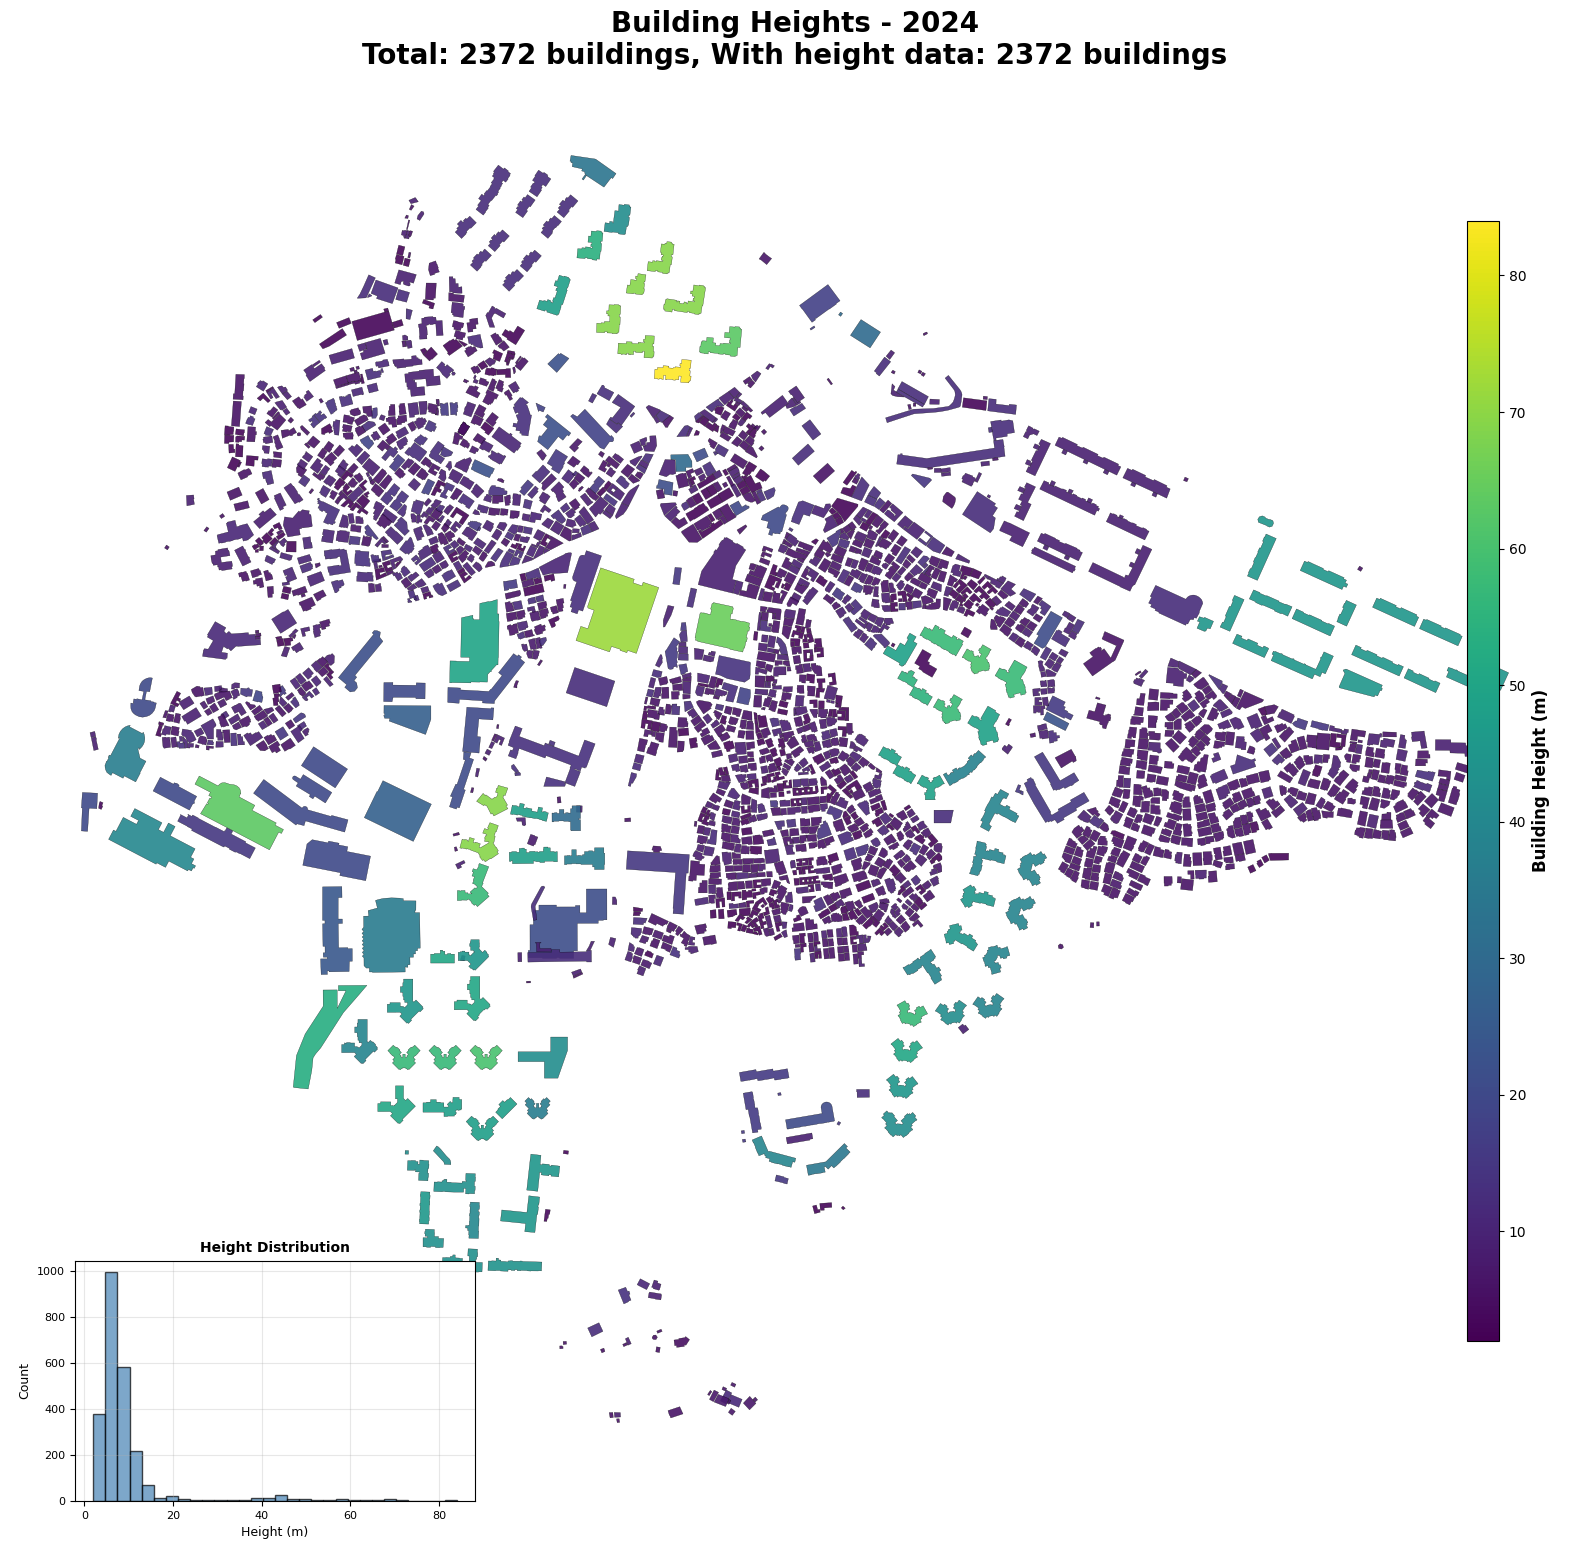

Creating categorical building height visualization...

Buildings by height category:
  Low-rise: 1936 buildings
  Mid-rise: 337 buildings
  High-rise: 71 buildings
  Skyscraper: 28 buildings

Figure saved to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/building_heights_categorical_2024.png


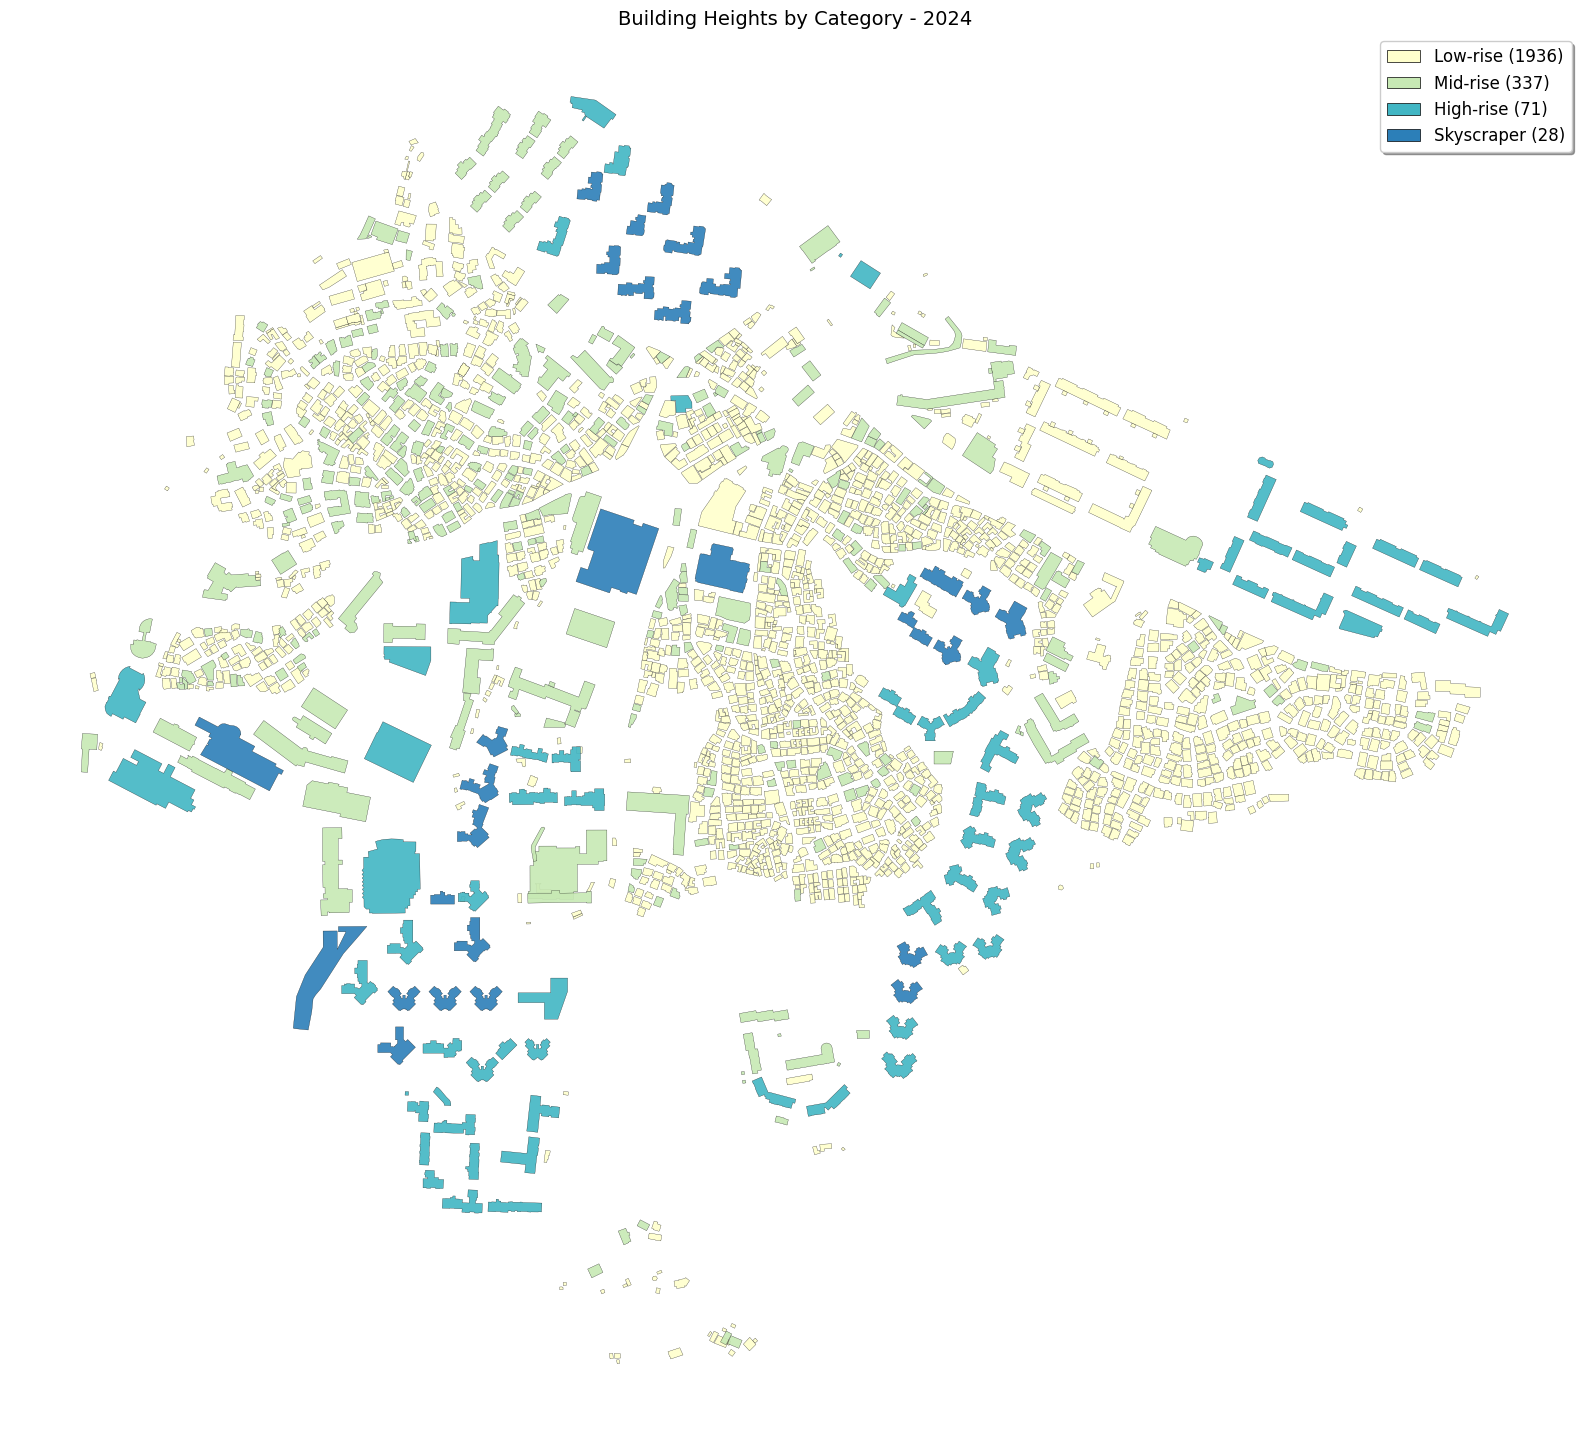

In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import numpy as np
import pandas as pd

def visualize_building_heights(shapefile_path, height_column='height', output_path=None, colormap='viridis'):
    """
    Visualize building heights using a gradient color scheme
    
    Parameters:
    -----------
    shapefile_path : str
        Path to the building shapefile
    height_column : str
        Name of the column containing building heights (default: 'height')
    output_path : str, optional
        Path to save the figure
    colormap : str
        Matplotlib colormap name (default: 'viridis')
        Options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'RdYlBu_r', 'coolwarm', etc.
    """
    
    print(f"Creating building height visualization...")
    
    # Load building shapefile
    print(f"Loading shapefile: {shapefile_path}")
    buildings_gdf = gpd.read_file(shapefile_path)
    print(f"Total buildings: {len(buildings_gdf)}")
    
    # Check available columns
    print(f"\nAvailable columns: {list(buildings_gdf.columns)}")
    
    # Find height column (case-insensitive search)
    height_col = None
    for col in buildings_gdf.columns:
        if col.lower() == height_column.lower() or 'height' in col.lower():
            height_col = col
            break
    
    if height_col is None:
        print(f"Warning: No height column found. Available columns: {list(buildings_gdf.columns)}")
        return None
    
    print(f"Using height column: '{height_col}'")
    
    # Convert height to numeric and handle missing values
    buildings_gdf[height_col] = pd.to_numeric(buildings_gdf[height_col], errors='coerce')
    
    # Filter out buildings with invalid heights
    valid_heights = buildings_gdf[buildings_gdf[height_col].notna() & (buildings_gdf[height_col] > 0)]
    invalid_heights = buildings_gdf[buildings_gdf[height_col].isna() | (buildings_gdf[height_col] <= 0)]
    
    print(f"\nBuildings with valid heights: {len(valid_heights)}")
    print(f"Buildings with invalid/missing heights: {len(invalid_heights)}")
    
    if len(valid_heights) == 0:
        print("No buildings with valid height data found.")
        return None
    
    # Calculate height statistics
    height_stats = {
        'min': valid_heights[height_col].min(),
        'max': valid_heights[height_col].max(),
        'mean': valid_heights[height_col].mean(),
        'median': valid_heights[height_col].median(),
        'std': valid_heights[height_col].std()
    }
    
    print(f"\nHeight Statistics:")
    print(f"  Min height: {height_stats['min']:.1f} m")
    print(f"  Max height: {height_stats['max']:.1f} m")
    print(f"  Mean height: {height_stats['mean']:.1f} m")
    print(f"  Median height: {height_stats['median']:.1f} m")
    print(f"  Std deviation: {height_stats['std']:.1f} m")
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    
    # Set up color normalization
    norm = Normalize(vmin=height_stats['min'], vmax=height_stats['max'])
    cmap = cm.get_cmap(colormap)
    
    # Plot buildings without height data in light gray
    if len(invalid_heights) > 0:
        invalid_heights.plot(ax=ax, 
                            color='#F0F0F0', 
                            edgecolor='#CCCCCC', 
                            linewidth=0.1,
                            alpha=0.5)
    
    # Plot buildings with heights using gradient colors
    valid_heights.plot(ax=ax,
                      column=height_col,
                      cmap=colormap,
                      edgecolor='black',
                      linewidth=0.2,
                      alpha=0.9,
                      legend=False)  # We'll create a custom colorbar
    
    # Create colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    # Add colorbar with custom settings
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Building Height (m)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add height intervals to colorbar
    height_range = height_stats['max'] - height_stats['min']
    if height_range > 0:
        # Add lines at quartiles
        quartiles = np.percentile(valid_heights[height_col], [25, 50, 75])
        for q in quartiles:
            cbar.ax.axhline((q - height_stats['min']) / height_range, 
                          color='white', linewidth=1, alpha=0.7)
    
    # Add title
    ax.set_title('Building Heights - 2024\n' + 
                f'Total: {len(buildings_gdf)} buildings, ' +
                f'With height data: {len(valid_heights)} buildings',
                fontsize=20, fontweight='bold', pad=20)
    
    # Remove axes
    ax.set_axis_off()
    
    # Add height distribution histogram as inset
    ax_hist = fig.add_axes([0.05, 0.05, 0.25, 0.15])  # [left, bottom, width, height]
    ax_hist.hist(valid_heights[height_col], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax_hist.set_xlabel('Height (m)', fontsize=9)
    ax_hist.set_ylabel('Count', fontsize=9)
    ax_hist.set_title('Height Distribution', fontsize=10, fontweight='bold')
    ax_hist.grid(True, alpha=0.3)
    ax_hist.tick_params(labelsize=8)
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return valid_heights, height_stats

def create_height_category_visualization(shapefile_path, height_column='height', output_path=None):
    """
    Create a categorical height visualization with custom height ranges
    """
    
    print(f"Creating categorical building height visualization...")
    
    # Load building shapefile
    buildings_gdf = gpd.read_file(shapefile_path)
    
    # Find height column
    height_col = None
    for col in buildings_gdf.columns:
        if col.lower() == height_column.lower() or 'height' in col.lower():
            height_col = col
            break
    
    if height_col is None:
        print(f"No height column found.")
        return None
    
    # Convert height to numeric
    buildings_gdf[height_col] = pd.to_numeric(buildings_gdf[height_col], errors='coerce')
    
    # Define height categories (in meters)
    height_categories = [
        (0, 10, 'Low-rise (0-10m)', '#ffffcc'),
        (10, 25, 'Mid-rise (10-25m)', '#c7e9b4'),
        (25, 50, 'High-rise (25-50m)', '#41b6c4'),
        (50, 100, 'Skyscraper (50-100m)', '#2c7fb8'),
        (100, float('inf'), 'Super tall (>100m)', '#253494')
    ]
    
    # Categorize buildings
    buildings_gdf['height_category'] = 'No data'
    buildings_gdf['color'] = '#F0F0F0'
    
    for min_h, max_h, category, color in height_categories:
        mask = (buildings_gdf[height_col] >= min_h) & (buildings_gdf[height_col] < max_h)
        buildings_gdf.loc[mask, 'height_category'] = category
        buildings_gdf.loc[mask, 'color'] = color
    
    # Count by category
    print("\nBuildings by height category:")
    category_counts = buildings_gdf['height_category'].value_counts()
    for cat, count in category_counts.items():
        print(f"  {cat}: {count} buildings")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    
    # Plot each category
    for min_h, max_h, category, color in height_categories:
        category_buildings = buildings_gdf[buildings_gdf['height_category'] == category]
        if len(category_buildings) > 0:
            category_buildings.plot(ax=ax,
                                  color=color,
                                  edgecolor='black',
                                  linewidth=0.2,
                                  alpha=0.9)
    
    # Plot buildings without data
    no_data = buildings_gdf[buildings_gdf['height_category'] == 'No data']
    if len(no_data) > 0:
        no_data.plot(ax=ax,
                    color='#F0F0F0',
                    edgecolor='#CCCCCC',
                    linewidth=0.1,
                    alpha=0.5)
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = []
    for min_h, max_h, category, color in height_categories:
        count = len(buildings_gdf[buildings_gdf['height_category'] == category])
        if count > 0:
            legend_elements.append(
                Patch(facecolor=color, edgecolor='black', linewidth=0.5,
                      label=f'{category} ({count})')
            )
    
    if len(no_data) > 0:
        legend_elements.append(
            Patch(facecolor='#F0F0F0', edgecolor='#CCCCCC', linewidth=0.5,
                  label=f'No data ({len(no_data)})')
        )
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12,
             frameon=True, fancybox=True, shadow=True)
    
    # Add title
    ax.set_title('Building Heights by Category - 2024',
                fontsize=14)
    
    # Remove axes
    ax.set_axis_off()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {output_path}")
    
    plt.show()
    
    return buildings_gdf

# Example usage
if __name__ == "__main__":
    # Set your path
    shapefile_path = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2020.shp"
    
    # Create gradient visualization
    output_path_gradient = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/building_heights_gradient_2024.png"
    valid_heights, stats = visualize_building_heights(
        shapefile_path,
        height_column='height',  # Adjust if your column has a different name
        output_path=output_path_gradient,
        colormap='viridis'  # Try 'plasma', 'RdYlBu_r', 'coolwarm' for different color schemes
    )
    
    # Create categorical visualization
    output_path_categorical = "/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/building_heights_categorical_2024.png"
    buildings_categorized = create_height_category_visualization(
        shapefile_path,
        height_column='height',
        output_path=output_path_categorical
    )